In [2]:
%matplotlib notebook


import numpy as np
import sys
import netCDF4 as nc4
import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms

In [3]:
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5SPH200702.nc','r')
#print(f)

#for var in f.variables.values():
#    print(var)

lat = f['lat'][:]
lon = f['lon'][:]
#Ta = f['tas'][:,:,:]
t = f['time'][:]
print(f)
h = f['hus'][:,:,:]
f.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2021-07-10T00:33 GRIB to CDM+CF via cfgrib-0.9.9.0/ecCodes-2.16.0 with {"source": "/cache/publicapps2/7e7e449c204f0b3bfcef919f8346d7e9.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    source: ECMWF
    dimensions(sizes): time(28), lat(721), lon(1440)
    variables(dimensions): int64 time(time), int64 realization(), float64 plev(), float64 lat(lat), float64 lon(lon), float32 hus(time,lat,lon)
    groups: 


<IPython.core.display.Javascript object>


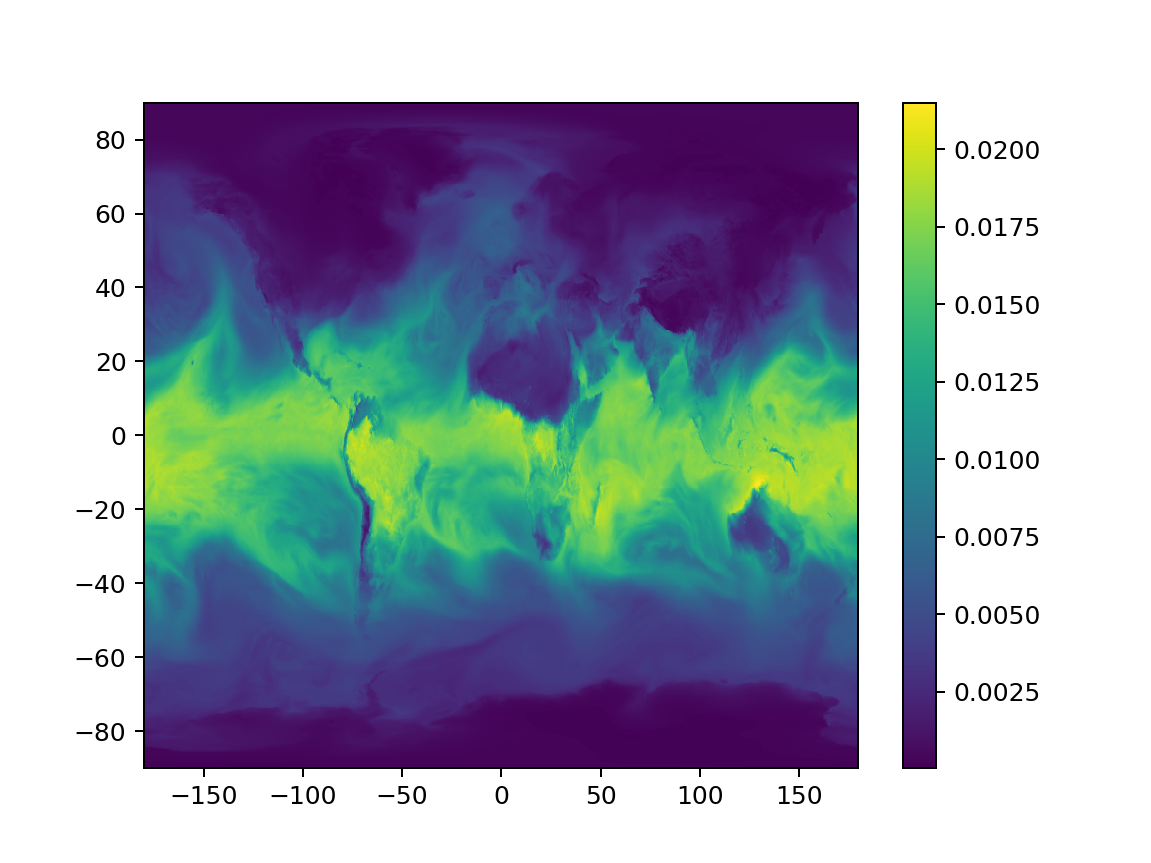

In [4]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(lon,lat,h[0,:,:])
fig.colorbar(pc,ax=ax)

In [4]:
def readin(timei,timef,datatype):
    
    
    '''
    Paramaters: time period over which you wish to read in data.
        timei = initial time in format 'yyyy/mm/01 00:00:00'
        (must be first day of the month)
        timef = final time in formal 'yyyy/mm/31 00:00:00'
        (must be the last day of the month)
        datatype = use either 'SST', 'TA' (air temp), or 'U' (wind speed)
        (must be a string)
    '''
    
    #first create str of all months and years (e.g.'yyyymm')
    #so they can be used to read in data in a loop  

    day1 = ddtime(1,timei)
    day2 = ddtime(1,timef)
    tnum = np.arange(day1, day2+1)
    ttemp = day_to_dt64(1,tnum)
    ttemp = dt64_to_ymdhms(ttemp)
    t = np.delete(ttemp,[2,3,4,5],axis=1)
    ym = np.unique(t,axis=0)
    
    ym_str = np.empty(len(ym),dtype = int) 
    for i in range(len(ym-1)):
        a = np.str(ym[i,0])
        b = np.str(ym[i,1])
        if len(b) == 1:
            b = '0' + b
        ym_str[i] = a+b
          
    
    #read data in
    filename = '/Users/baileydonaldson/python/ERA5/ERA5' + datatype + np.str(ym_str[0]) +'.nc'
    f = nc4.Dataset(filename)
    lat = f['lat'][:]
    lon = f['lon'][:]
    
    j=0
    data = np.empty([len(tnum),len(lat),len(lon)])
    dataK = np.empty([len(tnum),len(lat),len(lon)])
    for i in range(len(ym)):
        filename = '/Users/baileydonaldson/python/ERA5/ERA5' + datatype + np.str(ym_str[i]) +'.nc'
        f = nc4.Dataset(filename)
        t = f['time'][:]
        k = j+len(t)   
        if datatype == 'SPH':
            data[j:k,:,:] = f['hus'][:,:,:]
        elif datatype == 'TA':  
            dataK[j:k,:,:] = f['tas'][:,:,:]
            data = dataK -273.15
        elif datatype == 'SST':
            dataK[j:k,:,:] = f['tos'][:,:,:]
            data = dataK -273.15
        elif datatype == 'U':
            data[j:k,:,:] = f['uas'][:,:,:]
        elif datatype == 'V':
            data[j:k,:,:] = f['vas'][:,:,:]
        else:
            print("Wrong data type. It needs to be either 'SST', 'TA', 'V', or 'U'")
        j=k
        f.close()
  
    return tnum, lat, lon, data



In [5]:
time, lat, lon, qa = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','SPH')
#_, _, _, sst = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','SST')
#_, _, _, U = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','U')
#_, _, _, V = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','V')



KeyboardInterrupt: 

In [6]:
_, _, _, sst = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','SST')

In [10]:
_, _, _, U = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','U')
_, _, _, V = readin('2003/01/01 00:00:00','2008/12/31 00:00:00','V')

In [12]:
#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5V.nc','w', format='NETCDF4',clobber=False)
ds = f.createGroup('Global_data')

ds.createDimension('lon', len(lon))
ds.createDimension('lat', len(lat))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')
v = ds.createVariable('Meridional Wind Speed','f4',('time','lat','lon'))

longitude[:] = lon
latitude[:] = lat
t[:] = time
v[:,:,:] = V


#Add global attributes
f.description = "Region = Global; Time = 2003/01/01 - 2008/12/31; ERA5"


#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'
v.units = 'm/s'


f.close()

#reference: https://pyhogs.github.io/intro_netcdf4.html
#reference: https://towardsdatascience.com/create-netcdf-files-with-python-1d86829127dd


## Calculate Heat Flux

In [5]:
def calculate_QL(SST,U):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL #W/m^2

In [6]:
def calculate_QS(SST, U, Ta):

    #constants
    rho = 1.178 #kg/m^3
    cp = 1000 #J/kg/K
    Ch = 0.001
    
    #Ta = SST*0.7
    
    QS = rho*cp*Ch*U*(SST - Ta)
    
    return QS #W/m^2



## Isolate Data Spatially or Temporally

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]

def data_point(lat,lon,data):
    idx_lat = find_nearest(latQ,lat)
    idx_lon = find_nearest(lonQ,lon)
    data_pt = data[idx_lat,idx_lon]
    
    #if np.isnan(data_pt == True):
    #    print("No data here")
    
    return data_pt


def data_slice(latpt,lonpt,data,lat=lat,lon=lon):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl


In [8]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''   
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time

In [9]:
def get_regions(N,region):
    N=N*0.25*0.5
    
    if region == 'A':

        #Agulhas (S to S and E to E)
        latERpt = [-51-(N-0.25),-32+(N+0.25)]
        lonERpt = [5-(N-0.25),80+(N+0.25)]
        latER,lonER,UER = data_slice(latERpt,lonERpt,U)
        _,_,VER = data_slice(latERpt,lonERpt,V)
        _,_,sstER = data_slice(latERpt,lonERpt,sst)        
        wspdER = np.sqrt(np.add(np.square(UER),np.square(VER)))
   
        return latER,lonER,wspdER,sstER

    elif region == 'GS':
        #Gulf Stream (36 N to 47.75 N and 289 W to 323.75 W)
        latWBCpt = [36-(N-0.25),47.75+(N+0.25)]
        lonWBCpt = [-71-(N-0.25),-36.25+(N+0.25)]
        latWBC,lonWBC,UWBC = data_slice(latWBCpt,lonWBCpt,U)
        _,_,VWBC = data_slice(latWBCpt,lonWBCpt,V)
        _,_,sstWBC = data_slice(latWBCpt,lonWBCpt,sst)
        wspdWBC = np.sqrt(np.add(np.square(UWBC),np.square(VWBC)))
        
        return latWBC,lonWBC,wspdWBC,sstWBC

    elif region == 'K':
        #Kuroshio (120 E to 180 E and 26 to 48 N)
        latKpt = [24-(N-0.25),48+(N+0.25)]
        lonKpt = [135-(N-0.25),180+(N+0.25)]
        latK,lonK,UK = data_slice(latKpt,lonKpt,U)
        _,_,VK = data_slice(latKpt,lonKpt,V)
        _,_,sstK = data_slice(latKpt,lonKpt,sst)
        wspdK = np.sqrt(np.add(np.square(UK),np.square(VK)))

        return latK,lonK,wspdK,sstK

    else:
        return 'Choose either region K, A, or GS'

## Taylor Expansion and Smoothing

In [10]:
def smooth(data, data2, N=17):
    '''
    Description:
    
    Paramaters: "data" will be smoothed, "data2" will NOT be smoothed but 
        it will be shortened to the same size as "data." "N" is the width
        and length of the squares over which "data" is smoothed
    '''
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize    
    W = data.shape[0]
    L = data.shape[1]
    datasum = np.zeros((W-N+1,L-N+1)) #row, column
    counts = np.zeros((W-N+1,L-N+1))    
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(data.shape[0])
    indx_col = np.arange(data.shape[1])
    
    for i in range(N):
    
        delrow = np.delete(indx_row,slice(ai,W-af))
        data_delrow = np.delete(data,delrow,0)
    
        for j in range(N):       
            
            #delete excess rows and columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            data_delrowcol = np.delete(data_delrow,delcol,1)   
            
            #count number of good values
            goodind = np.where(np.isnan(data_delrowcol) == False)
            counts[goodind] = counts[goodind] + 1
            
            #change NaN to zero then add
            data_delrowcol[np.isnan(data_delrowcol) == True] = 0
            datasum = datasum + data_delrowcol     

            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    datasmooth = datasum/counts
    datasmooth[np.where(counts < (N**2)/2)] = None
    
    #delete points that were NaN in original data    
    a = int((N-1)/2)
    datashort = data[a:W-a, a:L-a]
    datasmooth[np.where(np.isnan(datashort) == True)] = None
    
    #makes data2 the same size as data
    data2short = data2[a:W-a, a:L-a]    
    

    
    return datasmooth, data2short


In [11]:
def QL_avg(SST,U,N=17):

    
    if SST.shape != U.shape:
        print("Shape of SST and U are unequal.")
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize
    W = SST.shape[0]
    L = SST.shape[1]
    SSTsum = np.zeros((W-N+1,L-N+1)) #row, column
    Usum = np.zeros((W-N+1,L-N+1))
    Qsum = np.zeros((W-N+1,L-N+1))
    Qcounts = np.zeros((W-N+1,L-N+1)) 
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])
    
    for i in range(N):
        
        #delete excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
    
        for j in range(N):       
            
            #delete excess columns 
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1)
            U_delrowcol = np.delete(U_delrow,delcol,1)
            
            #count number of good values
            Qgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            Qcounts[Qgoodind] = Qcounts[Qgoodind] + 1
            
            #change NaN to zero then add
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0            
            Qsum = Qsum + calculate_QL(SST_delrowcol,U_delrowcol)     
            
            bi = bi-1
            bf = bf+1

        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 

    QL_avg = Qsum/Qcounts
    QL_avg[np.where(Qcounts < (N**2)/2)] = None                         

    return QL_avg  


In [12]:
def deviation_avg(SST,U,SSTsm,Usm,N=17):
    '''
    Paramaters:
    SST and U is data that has NOT been shortened 
    
    SSTsm and Usm are already smoothed data that is shorter than SST
        and U by N indicies in both rows and columns.
    
    '''
    
    
    
    #calculate Ti_avg and Ui_avg
    N = (int(N/2)*2)+1 #make N odd

    if SST.shape != U.shape:
        print('Shape of SST and U are unequal.')
    elif SSTsm.shape != Usm.shape:
        print('Shape of SSTsm and Usm are unequal.')
    elif SST.shape == SSTsm.shape:
        print('SSTsm is too large or SST is to small')
    elif U.shape == Usm.shape:
        print('Usm is too large or U is to small')
    
    #initialize    
    W = SST.shape[0]
    L = SST.shape[1] 
    SSTcounts = np.zeros((W-N+1,L-N+1))  #row, column 
    Ucounts = np.zeros((W-N+1,L-N+1)) 
    USSTcounts = np.zeros((W-N+1,L-N+1)) 
    Ti_sum = np.zeros((W-N+1,L-N+1))
    Ui_sum = np.zeros((W-N+1,L-N+1))
    Ti2_sum = np.zeros((W-N+1,L-N+1))
    UiTi_sum = np.zeros((W-N+1,L-N+1))
    T_std = np.zeros((W-N+1,L-N+1))
    #nan_idx = np.zeros((W-N+1,L-N+1))
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])

    for i in range(N):
        #deletes excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
    
        for j in range(N):       
            
            #delete excess columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1) 
            U_delrowcol = np.delete(U_delrow,delcol,1)
            
            #count number of good values
            SSTgoodind = np.where(np.isnan(SST_delrowcol) == False)
            SSTcounts[SSTgoodind] = SSTcounts[SSTgoodind] + 1
            
            Ugoodind = np.where(np.isnan(U_delrowcol) == False)
            Ucounts[Ugoodind] = Ucounts[Ugoodind] + 1
            
            USSTgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            USSTcounts[USSTgoodind] = USSTcounts[USSTgoodind] + 1
            
            #save array of bad indicies 
            #bad_idx = np.where(np.isnan(U_delrowcol) == True) 
            #nan_idx[bad_idx] = 1                               
            #bad_idx = np.where(np.isnan(SST_delrowcol) == True)
            #nan_idx[bad_idx] = 1

            
            #change NaN to zeros
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0
    
            #subtract averaged from mean (mean found above in smoothing)
            Ti_sum = Ti_sum + SST_delrowcol - SSTsm
            Ui_sum = Ui_sum + U_delrowcol - Usm
            Ti2_sum = Ti2_sum + (SST_delrowcol - SSTsm)**2
            UiTi_sum = UiTi_sum + (SST_delrowcol - SSTsm)*(U_delrowcol - Usm)
                        
            
            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    #take average
    Ti_avg = Ti_sum/SSTcounts
    Ui_avg = Ui_sum/Ucounts
    Ti2_avg = Ti2_sum/SSTcounts
    UiTi_avg = UiTi_sum/USSTcounts
    
    #standard deviation 
    T_std = np.sqrt(Ti2_avg)
    
   #nan_idx = np.where(np.isnan(UiTi_avg == False))
    
    #Necessary??? Or No???
    Ti_avg[np.where(SSTcounts < (N**2))] = None
    Ui_avg[np.where(Ucounts < (N**2))] = None
    Ti2_avg[np.where(SSTcounts < (N**2))] = None
    UiTi_avg[np.where(SSTcounts < (N**2))] = None    
    UiTi_avg[np.where(Ucounts < (N**2))] = None  
    
    return Ti_avg, Ui_avg, Ti2_avg, UiTi_avg#, T_std, nan_idx

    

In [13]:
def taylorexp_QLavg(SST,U,N=17,D=0.1):
    '''
    Takes the taylor expansion over the large scale state.
    
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    N = smoothing
    D = delta
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)

        Ti_avg, Ui_avg, Ti2_avg, UiTi_avg = deviation_avg(SST,U,SSTsm,Usm,N=N)
        std = np.sqrt(Ti2_avg)
        
        #average heat flux
        Q0 = QL_avg(SST,U,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size)
        
        Q0 = np.empty(size)
        Q1 = np.empty(size)
        
        Ti_avg = np.empty(size) 
        Ui_avg = np.empty(size) 
        Ti2_avg = np.empty(size) 
        UiTi_avg = np.empty(size)      
        nan_idx = np.empty(size)
        
        std = np.empty(size)
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N)         

            Ti_avg[i,:,:], Ui_avg[i,:,:], Ti2_avg[i,:,:], UiTi_avg[i,:,:] \
            = deviation_avg(SST[i,:,:],U[i,:,:],SSTsm[i,:,:],Usm[i,:,:],N=N)
            
            std[i,:,:] = np.sqrt(Ti2_avg[i,:,:])
            
            #average heat flux
            Q0[i,:,:] = QL_avg(SST[i,:,:],U[i,:,:],N)
       
    else:
        print("Number of Dimensions is Unequal.")
  

        
    #First Taylor Expansion term: Q(T_sm,U_sm) 
    Q1 = calculate_QL(SSTsm,Usm)

    #Second Taylor Expansion term: 
    Q_DT = (calculate_QL(SSTsm+D,Usm) - calculate_QL(SSTsm-D,Usm))/(2*D)
    Q2 = Q_DT*Ti_avg
    
    #Third Taylor Expansion term: 
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL(SSTsm,Usm+D) - calculate_QL(SSTsm,Usm-D))/(2*D)
    Q3 = Q_DU*Ui_avg
    
    #Fourth Taylor Expansion term: {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL(SSTsm+D,Usm) - 2*Q1 + calculate_QL(SSTsm-D,Usm)) / (D**2)
    Q4 = (Q_DTT * Ti2_avg) / 2
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')^2
    Q_DTDU = (calculate_QL(SSTsm+D,Usm+D)-calculate_QL(SSTsm+D,Usm-D) - \
        calculate_QL(SSTsm-D,Usm+D)+calculate_QL(SSTsm-D,Usm-D))/(4*D*D)
    Q5 = Q_DTDU * UiTi_avg

    #Sixth Taylor Expansion term: Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_DUU = 0
    
    
    nan_idx = np.where(np.isnan(Q5) == True)
    Q0[nan_idx] = None
    Q1[nan_idx] = None
    Q2[nan_idx] = None
    Q3[nan_idx] = None
    Q4[nan_idx] = None
    
    return Q0, Q1, Q2, Q3, Q4, Q5, std 
    
    

In [14]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data you wish to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,1]) + '/' + str(ym_uniq[i,0]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str



In [15]:
def annual_avg(data,ym,dimension=None):
    
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)

    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0]))
    
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)
    
    data_avg1D = np.empty(ylen)
    data_avg2D = np.empty([ylen,data.shape[1],data.shape[2]])

    
    for i in range(ylen):
        if dimension == "1D":
            data_avg1D[i] = np.nanmean(data[idx[i]:idx[i+1]]) 
        elif dimension == "2D":
            data_avg2D[i,:,:] = np.nanmean(data[idx[i]:idx[i+1]],axis=0)

    if dimension == "1D":
        return data_avg1D,y
        
    elif dimension == "2D":
        return data_avg2D,y


In [16]:
def seasonal_avg(data,ym):
    '''
    Takes seasonal average of the entire data set, combining the years together to 
    produce a 4 separate data arrays that have a spatial represention for each season. 
    '''
    data_DJF = data[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

    data_MAM = data[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

    data_JJA = data[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

    data_SON = data[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

    DJF_avg = np.nanmean(data_DJF,axis=0)
    MAM_avg = np.nanmean(data_MAM,axis=0)
    JJA_avg = np.nanmean(data_JJA,axis=0)
    SON_avg = np.nanmean(data_SON,axis=0)
    
    return DJF_avg, MAM_avg, JJA_avg, SON_avg

In [17]:
def seasonal_avg2(data,ym,dimension=None):
    '''
    Takes seasonal average for each year. Does not combine the years together.
    Winter season includes december from the previous year. 
    Ex: DJF could be 12/2002, 1/2003, and 2/2003
    
    ym = [year, month] [year, month] ... shaped arrays that are the same 
    length as the first indice of the data array. Can obtain in monthly_avg function.
    
    '''
    
    #create indexing that isolates years from December of previous year to November
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)
    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0])-1)
    #subtract by 31 to include December from the previous year
    idx = idx-31
    #turn first index into 0 so it doesnt pull december from a different year
    idx[0]=0
    
    #get number of years for appending purposes in loop
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)

    
    #initialize
    size = [ylen,data.shape[1],data.shape[2]]
    DJF_avg2D = np.empty(size)
    MAM_avg2D = np.empty(size)
    JJA_avg2D = np.empty(size)
    SON_avg2D = np.empty(size)
    
    DJF_avg = np.empty(ylen)
    MAM_avg = np.empty(ylen)
    JJA_avg = np.empty(ylen)
    SON_avg = np.empty(ylen)    
    
    for i in range(ylen):
        #isolates time array and data by each year
        ymtemp = ym[idx[i]:idx[i+1],1]
        datatemp = data[idx[i]:idx[i+1],:,:]
        
        #isolates data by seasons, still in 3D arrays
        data_DJF = datatemp[(ymtemp == 12) | (ymtemp == 1) | (ymtemp == 2),:,:]
        data_MAM = datatemp[(ymtemp == 3) | (ymtemp == 4) | (ymtemp == 5),:,:]
        data_JJA = datatemp[(ymtemp == 6) | (ymtemp == 7) | (ymtemp == 8),:,:]
        data_SON = datatemp[(ymtemp == 9) | (ymtemp == 10) | (ymtemp == 11),:,:]
        
        if dimension == "2D":
            
            DJF_avg2D[i,:,:] = np.nanmean(data_DJF,axis=0)
            MAM_avg2D[i,:,:] = np.nanmean(data_MAM,axis=0)
            JJA_avg2D[i,:,:] = np.nanmean(data_JJA,axis=0)
            SON_avg2D[i,:,:] = np.nanmean(data_SON,axis=0)
            
        elif dimension == "1D":
            DJF_avg[i] = np.nanmean(data_DJF)
            MAM_avg[i] = np.nanmean(data_MAM)
            JJA_avg[i] = np.nanmean(data_JJA)
            SON_avg[i] = np.nanmean(data_SON)
         
        else:
            print("Select a dimension to average over. Choose either '1D' or '2D'")
        
    print("December of", y[0]-1,"is not included in DJF for",y[0])
    
    if dimension == "2D":
        return DJF_avg2D, MAM_avg2D, JJA_avg2D, SON_avg2D, y
    elif dimension == "1D":
        return DJF_avg, MAM_avg, JJA_avg, SON_avg, y


# Calculate Heat Flux with Specific Humidity


In [18]:
def calculate_QL2(SST,U,qa):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    #qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL #W/m^2

In [19]:
def QL_avg2(SST,U,SPH,N=17):

    
    if SST.shape != U.shape:
        print("Shape of SST and U are unequal.")
    
    #this ensures that N is an odd number
    N = (int(N/2)*2)+1
    
    #initialize
    W = SST.shape[0]
    L = SST.shape[1]
    SSTsum = np.zeros((W-N+1,L-N+1)) #row, column
    SPHsum = np.zeros((W-N+1,L-N+1))
    Usum = np.zeros((W-N+1,L-N+1))
    Qsum = np.zeros((W-N+1,L-N+1))
    Qcounts = np.zeros((W-N+1,L-N+1)) 
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])
    
    for i in range(N):
        
        #delete excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
        SPH_delrow = np.delete(SPH,delrow,0)
    
        for j in range(N):       
            
            #delete excess columns 
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1)
            U_delrowcol = np.delete(U_delrow,delcol,1)
            SPH_delrowcol = np.delete(SPH_delrow,delcol,1)
            
            #count number of good values
            Qgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            Qcounts[Qgoodind] = Qcounts[Qgoodind] + 1
            
            #change NaN to zero then add
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0  
            SPH_delrowcol[np.isnan(SPH_delrowcol) == True] = 0  
            Qsum = Qsum + calculate_QL2(SST_delrowcol,U_delrowcol,SPH_delrowcol)     
            
            bi = bi-1
            bf = bf+1

        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 

    QL_avg = Qsum/Qcounts
    QL_avg[np.where(Qcounts < (N**2)/2)] = None                         

    return QL_avg  


In [20]:
def deviation_avg2(SST,U,SPH,SSTsm,Usm,SPHsm,N=17):
    '''
    Paramaters:
    SST and U and SPH is data that has NOT been shortened 
    
    SSTsm and Usm are already smoothed data that is shorter than SST
        and U by N indicies in both rows and columns.
    
    '''
    
    #calculate Ti_avg and Ui_avg
    N = (int(N/2)*2)+1 #make N odd

    if SST.shape != U.shape:
        print('Shape of SST and U are unequal.')
    elif SSTsm.shape != Usm.shape:
        print('Shape of SSTsm and Usm are unequal.')
    elif SST.shape == SSTsm.shape:
        print('SSTsm is too large or SST is to small')
    elif U.shape == Usm.shape:
        print('Usm is too large or U is to small')
    
    #initialize    
    W = SST.shape[0]
    L = SST.shape[1] 
    SSTcounts = np.zeros((W-N+1,L-N+1))  #row, column 
    Ucounts = np.zeros((W-N+1,L-N+1)) 
    Hcounts = np.zeros((W-N+1,L-N+1)) 
    USSTcounts = np.zeros((W-N+1,L-N+1)) 
    UHcounts = np.zeros((W-N+1,L-N+1))
    SSTHcounts = np.zeros((W-N+1,L-N+1))
    
    Ti_sum = np.zeros((W-N+1,L-N+1))
    Ui_sum = np.zeros((W-N+1,L-N+1))
    Hi_sum = np.zeros((W-N+1,L-N+1))
    Ti2_sum = np.zeros((W-N+1,L-N+1))
    Hi2_sum = np.zeros((W-N+1,L-N+1))
    UiTi_sum = np.zeros((W-N+1,L-N+1))
    UiHi_sum = np.zeros((W-N+1,L-N+1))
    TiHi_sum = np.zeros((W-N+1,L-N+1))
    T_std = np.zeros((W-N+1,L-N+1))
    
    #nan_idx = np.zeros((W-N+1,L-N+1))
    ai = N-1
    af = 0
    bi = N-1
    bf = 0
    indx_row = np.arange(SST.shape[0])
    indx_col = np.arange(SST.shape[1])

    for i in range(N):
        #deletes excess rows 
        delrow = np.delete(indx_row,slice(ai,W-af))
        SST_delrow = np.delete(SST,delrow,0)
        U_delrow = np.delete(U,delrow,0)
        H_delrow = np.delete(SPH,delrow,0)        
    
        for j in range(N):       
            
            #delete excess columns
            delcol = np.delete(indx_col,slice(bi,L-bf))
            SST_delrowcol = np.delete(SST_delrow,delcol,1) 
            U_delrowcol = np.delete(U_delrow,delcol,1)
            H_delrowcol = np.delete(H_delrow,delcol,1)
            
            
            #count number of good values
            SSTgoodind = np.where(np.isnan(SST_delrowcol) == False)
            SSTcounts[SSTgoodind] = SSTcounts[SSTgoodind] + 1
            
            Ugoodind = np.where(np.isnan(U_delrowcol) == False)
            Ucounts[Ugoodind] = Ucounts[Ugoodind] + 1

            Hgoodind = np.where(np.isnan(H_delrowcol) == False)
            Hcounts[Hgoodind] = Hcounts[Hgoodind] + 1            
            
            USSTgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(SST_delrowcol) == False))
            USSTcounts[USSTgoodind] = USSTcounts[USSTgoodind] + 1
            
            UHgoodind  = np.where((np.isnan(U_delrowcol) == False) & (np.isnan(H_delrowcol) == False))
            UHcounts[UHgoodind] = UHcounts[UHgoodind] + 1            

            SSTHgoodind  = np.where((np.isnan(SST_delrowcol) == False) & (np.isnan(H_delrowcol) == False))
            SSTHcounts[SSTHgoodind] = SSTHcounts[SSTHgoodind] + 1                 
            
            
            #change NaN to zeros
            SST_delrowcol[np.isnan(SST_delrowcol) == True] = 0
            U_delrowcol[np.isnan(U_delrowcol) == True] = 0
            H_delrowcol[np.isnan(H_delrowcol) == True] = 0
    
    
            #subtract averaged from mean (mean found above in smoothing)
            Ti_sum = Ti_sum + SST_delrowcol - SSTsm
            Ui_sum = Ui_sum + U_delrowcol - Usm
            Hi_sum = Hi_sum + H_delrowcol - SPHsm
            Hi2_sum = Hi2_sum + (H_delrowcol - SPHsm)**2
            Ti2_sum = Ti2_sum + (SST_delrowcol - SSTsm)**2
            UiTi_sum = UiTi_sum + (SST_delrowcol - SSTsm)*(U_delrowcol - Usm)
            UiHi_sum = UiHi_sum + (U_delrowcol - Usm)*(H_delrowcol - SPHsm)
            TiHi_sum = TiHi_sum + (SST_delrowcol - SSTsm)*(H_delrowcol - SPHsm) 
            
            bi = bi-1
            bf = bf+1
        ai = ai-1
        af = af+1
        bi = N-1
        bf = 0 
    
    #take average
    Ti_avg = Ti_sum/SSTcounts
    Ui_avg = Ui_sum/Ucounts
    Hi_avg = Hi_sum/Hcounts
    Hi2_avg = Hi2_sum/Hcounts
    Ti2_avg = Ti2_sum/SSTcounts
    UiTi_avg = UiTi_sum/USSTcounts
    UiHi_avg = UiHi_sum/UHcounts
    TiHi_avg = TiHi_sum/SSTHcounts
    
    #standard deviation 
    T_std = np.sqrt(Ti2_avg)
    
    #nan_idx = np.where(np.isnan(UiTi_avg == False))
    
    #Necessary??? Or No???
    Ti_avg[np.where(SSTcounts < (N**2))] = None
    Ui_avg[np.where(Ucounts < (N**2))] = None
    Ti2_avg[np.where(SSTcounts < (N**2))] = None
    
    UiTi_avg[np.where(SSTcounts < (N**2))] = None    
    UiTi_avg[np.where(Ucounts < (N**2))] = None 

    UiHi_avg[np.where(Hcounts < (N**2))] = None    
    UiHi_avg[np.where(Ucounts < (N**2))] = None 
    
    TiHi_avg[np.where(SSTcounts < (N**2))] = None    
    TiHi_avg[np.where(Hcounts < (N**2))] = None 
    
    
    return Ti_avg, Ui_avg, Hi_avg, Hi2_avg, Ti2_avg, UiTi_avg, UiHi_avg, TiHi_avg

    

In [1]:
def taylorexp_QLavg2(SST,U,SPH,N=17,D=0.1,DH=0.00001):
    '''
    Takes the taylor expansion over the large scale state.
    
    SST = sea surface temperature of your choice (must be same size as U)
    U = Wind velocity of your choice (must be same size as SST)
    SPH = Specific Humidity
    N = smoothing
    D = delta
    
    '''
    
    if SST.ndim == 2 and U.ndim == 2:
        #get smoothed SST and U and their shortened unsmoothed counterparts
        SSTsm, Ush = smooth(SST,U,N)
        Usm, SSTsh = smooth(U,SST,N)
        SPHsm, SPHsh = smooth(SPH,SPH,N)

        Ti_avg, Ui_avg, Hi_avg, Hi2_avg, Ti2_avg, UiTi_avg, UiHi_avg, TiHi_avg = deviation_avg2(SST,U,SPH,SSTsm,Usm,SPHsm,N=N)
        stdT = np.sqrt(Ti2_avg)
        stdH = np.sqrt(Hi2_avg)
        
        #average heat flux
        Q0 = QL_avg2(SST,U,SPH,N)
        
    elif SST.ndim == 3 and U.ndim == 3:
        
        #get smoothed SST and U and their shortened unsmoothed counterparts
        T = SST.shape[0]
        W = SST.shape[1]
        L = SST.shape[2]
        size = [T,W-N+1,L-N+1]
        
        SSTsm = np.empty(size)
        Ush = np.empty(size)
        SSTsh = np.empty(size)
        Usm = np.empty(size)
        SPHsh = np.empty(size)
        SPHsm = np.empty(size)
        
        Q0 = np.empty(size)
        Q1 = np.empty(size)
        
        Ti_avg = np.empty(size) 
        Hi_avg = np.empty(size) 
        Ui_avg = np.empty(size) 
        Ti2_avg = np.empty(size) 
        Hi2_avg = np.empty(size) 
        UiTi_avg = np.empty(size)
        UiHi_avg = np.empty(size)
        TiHi_avg = np.empty(size)
        nan_idx = np.empty(size)
        
        stdT = np.empty(size)
        stdH = np.empty(size)
        
        for i in range(T):
            SSTsm[i,:,:], Ush[i,:,:] = smooth(SST[i,:,:],U[i,:,:],N)
            Usm[i,:,:], SSTsh[i,:,:] = smooth(U[i,:,:],SST[i,:,:],N) 
            SPHsm[i,:,:], SPHsh[i,:,:] = smooth(SPH[i,:,:], SPH[i,:,:],N)
            
            Ti_avg[i,:,:], Ui_avg[i,:,:], Hi_avg[i,:,:], Hi2_avg[i,:,:], Ti2_avg[i,:,:], UiTi_avg[i,:,:], UiHi_avg[i,:,:], TiHi_avg[i,:,:] \
            = deviation_avg2(SST[i,:,:],U[i,:,:],SPH[i,:,:],SSTsm[i,:,:],Usm[i,:,:],SPHsm[i,:,:],N=N)
            
            stdT[i,:,:] = np.sqrt(Ti2_avg[i,:,:])
            stdH[i,:,:] = np.sqrt(Hi2_avg[i,:,:])
            
            #average heat flux
            Q0[i,:,:] = QL_avg2(SST[i,:,:],U[i,:,:],SPH[i,:,:],N)
       
    else:
        print("Number of Dimensions is Unequal.")
  

        
    #First Taylor Expansion term: Q(T_sm,U_sm) 
    Q1 = calculate_QL2(SSTsm,Usm,SPHsm)

    
    #Taylor Expansion term (linear): Q_T*T'
    Q_DT = (calculate_QL2(SSTsm+(D/2),Usm,SPHsm) - calculate_QL2(SSTsm-(D/2),Usm,SPHsm))/(D)
    Q2a = Q_DT*Ti_avg #SHOULD I DO SPH+D OR NO?
    
    #Taylor Expansion term (linear): Q_U*U'
    #Q_DU = Q/Ushort
    Q_DU = (calculate_QL2(SSTsm,Usm+(D/2),SPHsm) - calculate_QL2(SSTsm,Usm-(D/2),SPHsm))/(D)
    Q2b = Q_DU*Ui_avg 
    
    #Taylor Expansion term (linear): 
    Q_DH = (calculate_QL2(SSTsm,Usm,SPHsm+(DH/2)) - calculate_QL2(SSTsm,Usm,SPHsm-(DH/2)))/(DH)
    Q2c = Q_DH*Hi_avg     

    
    #Taylor Expansion term (nonlinear): {Q_tt(T_sm,U_sm) * (T')^2} / 2!
    Q_DTT = (calculate_QL2(SSTsm+D,Usm,SPHsm) - 2*Q1 + calculate_QL2(SSTsm-D,Usm,SPHsm)) / (D**2) #ERROR?
    Q4 = (Q_DTT * Ti2_avg) / 2
    
    
    #Fifth Taylor Expansion term: Q_ut(T_sm,U_sm) * (T'U')
    Q_DTDU = (calculate_QL2(SSTsm+D,Usm+D,SPHsm)-calculate_QL2(SSTsm+D,Usm-D,SPHsm) - \
        calculate_QL2(SSTsm-D,Usm+D,SPHsm)+calculate_QL2(SSTsm-D,Usm-D,SPHsm))/(4*D*D) #ERROR?
    Q5 = Q_DTDU * UiTi_avg #SHOULD I DO SPH+D OR NO?
  
    
    #Sixth Taylor Expansion term (nonlinear): Q_uh*(U'H')/(D*DH)
    #Q_DUDH = (calculate_QL2(SSTsm,Usm+(D/2),SPHsm+(DH/2)) - calculate_QL2(SSTsm,Usm-(D/2),SPHsm+(DH/2)) - \
    #    calculate_QL2(SSTsm,Usm-(D/2),SPHsm-(DH/2)) + calculate_QL2(SSTsm,Usm-(D/2),SPHsm-(DH/2)))/(D*DH)
    rho = 1.178
    Ce = .001
    Lv = 2500000
    Q_DUDH = Lv*rho*Ce*(-1)
    Q6 = Q_DUDH * UiHi_avg
    
    
    #Seventh Taylor Expansion term (nonlinear): (Q_th*T'H')/(D*DH)
    #Q_DTDH = (calculate_QL2(SSTsm+(D/2),Usm,SPHsm+(DH/2)) - calculate_QL2(SSTsm-(D/2),Usm,SPHsm+(DH/2)) - \
    #    calculate_QL2(SSTsm+(D/2),Usm,SPHsm-(DH/2)) + calculate_QL2(SSTsm-(D/2),Usm,SPHsm-(DH/2)))/(D*DH)
    #Q7 = Q_DTDH * TiHi_avg
    
    
    #Eighth Taylor Expansion term (nonlinear): Q_uu(T_sm,Usm)*(U')^2} / 2!
    Q_UU = 0
    #Ninth Taylor Expansion term (nonlinear): Q_hh*(H')^2 / 2!
    Q_HH = 0
    
    nan_idx = np.where(np.isnan(UiTi_avg) == True)
    Q0[nan_idx] = None
    Q1[nan_idx] = None
    Q2a[nan_idx] = None
    Q2b[nan_idx] = None
    Q2c[nan_idx] = None
    Q4[nan_idx] = None
    Q5[nan_idx] = None
    Q6[nan_idx] = None
    stdH[nan_idx] = None
    
    return Q0, Q1, Q2a, Q2b, Q2c, Q4, Q5, Q6, stdT, stdH
    
    

In [22]:
def get_regions2(N,region):
    N=N*0.25*0.5
    
    if region == 'A':

        #Agulhas (S to S and E to E)
        latERpt = [-51-(N-0.25),-32+(N+0.25)]
        lonERpt = [5-(N-0.25),80+(N+0.25)]
        latER,lonER,UER = data_slice(latERpt,lonERpt,U)
        _,_,VER = data_slice(latERpt,lonERpt,V)
        _,_,sstER = data_slice(latERpt,lonERpt,sst)
        _,_,qaER = data_slice(latERpt,lonERpt,qa)  
        wspdER = np.sqrt(np.add(np.square(UER),np.square(VER)))
   
        return latER,lonER,wspdER,sstER,qaER

    elif region == 'GS':
        #Gulf Stream (36 N to 47.75 N and 289 W to 323.75 W)
        latWBCpt = [36-(N-0.25),47.75+(N+0.25)]
        lonWBCpt = [-71-(N-0.25),-36.25+(N+0.25)]
        latWBC,lonWBC,UWBC = data_slice(latWBCpt,lonWBCpt,U)
        _,_,VWBC = data_slice(latWBCpt,lonWBCpt,V)
        _,_,sstWBC = data_slice(latWBCpt,lonWBCpt,sst)
        _,_,qaWBC = data_slice(latWBCpt,lonWBCpt,qa) 
        wspdWBC = np.sqrt(np.add(np.square(UWBC),np.square(VWBC)))
        
        return latWBC,lonWBC,wspdWBC,sstWBC,qaWBC

    elif region == 'K':
        #Kuroshio (120 E to 180 E and 26 to 48 N)
        latKpt = [24-(N-0.25),48+(N+0.25)]
        lonKpt = [135-(N-0.25),180+(N+0.25)]
        latK,lonK,UK = data_slice(latKpt,lonKpt,U)
        _,_,VK = data_slice(latKpt,lonKpt,V)
        _,_,sstK = data_slice(latKpt,lonKpt,sst)
        _,_,qaK = data_slice(latKpt,lonKpt,qa) 
        wspdK = np.sqrt(np.add(np.square(UK),np.square(VK)))

        return latK,lonK,wspdK,sstK,qaK

    else:
        return 'Choose either region K, A, or GS'

In [24]:
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5Qa.nc','r')
grp = f.groups['Global_data']
print(f)
lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
qa = grp.variables['Specific Humidity'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5SST.nc','r')
grp = f.groups['Global_data']
sst = grp.variables['Sea Surface Temperature'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5U.nc','r')
grp = f.groups['Global_data']
U = grp.variables['Zonal Wind Speed'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/ERA5V.nc','r')
grp = f.groups['Global_data']
V = grp.variables['Meridional Wind Speed'][:,:,:]
f.close()

time = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
#_, ym, _ = monthly_avg(Q, time)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Global; Time = 2003/01/01 - 2008/12/31; ERA5
    dimensions(sizes): 
    variables(dimensions): 
    groups: Global_data


In [26]:
N=11
D=0.1
D2 = 0.00001
latK,lonK,wspdK,sstK,qaK = get_regions2(N,'GS')
a = np.int((N-1)/2)
lonK2 = lonK[a:len(lonK)-a]
latK2 = latK[a:len(latK)-a]


In [50]:
day=100
Q0, Q1, Q2a, Q2b, Q2c, Q4, Q5, Q6, stdT, stdH = \
    taylorexp_QLavg2(sstK[day:day+2,:,:],wspdK[day:day+2,:,:],qaK[day:day+2,:,:],N=N,D=0.1,DH=0.00055/2)



5.753852840163739e-05
(2, 48, 140)


<IPython.core.display.Javascript object>


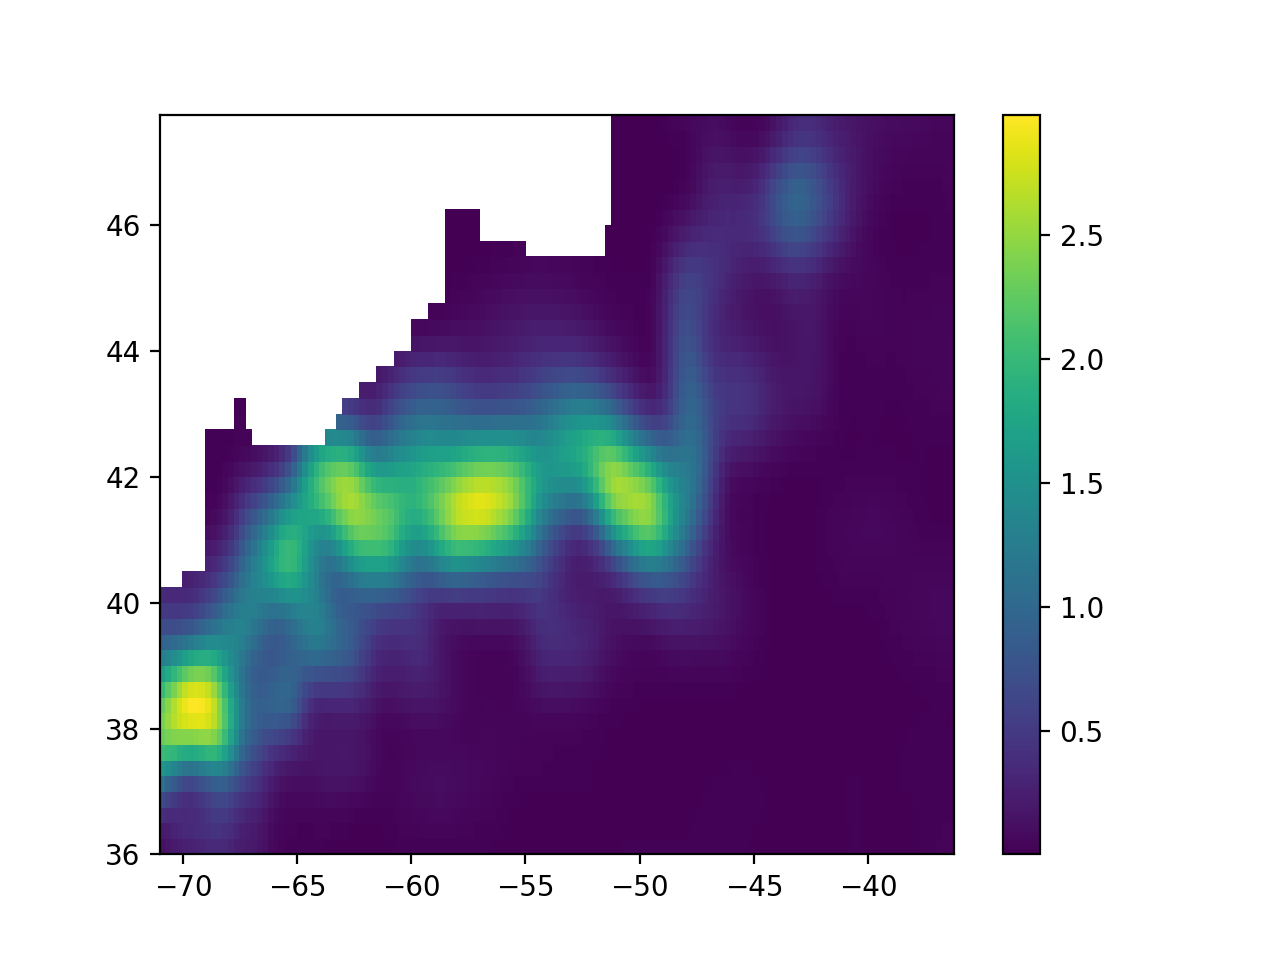

In [52]:
print(np.nanmean(stdH)*.1)
print(Q4.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(lonK2,latK2,Q4[1,:,:])
fig.colorbar(pc,ax=ax)

# やる

In [62]:
N=13
latK,lonK,wspdK,sstK,qaK = get_regions2(N,'K')
Q_K, Q1_K, Q2a_K, Q2b_K, Q2c_K, Q4_K, Q5_K, Q6_K, stdT_K, stdH_K = taylorexp_QLavg2(sstK,wspdK,qaK,N=N,D=0.1,DH=0.00055/2)

a = np.int((N-1)/2)
lonK2 = lonK[a:len(lonK)-a]
latK2 = latK[a:len(latK)-a]

size = Q_K.shape
wspdKsm = np.empty(size)
wspdKsh = np.empty(size)
sstKsm = np.empty(size)
sstKsh = np.empty(size)
qaKsm = np.empty(size)
qaKsh = np.empty(size)

for i in range(len(time)):
    wspdKsm[i,:,:], wspdKsh[i,:,:] = smooth(wspdK[i,:,:], wspdK[i,:,:], N=N)
    sstKsm[i,:,:],sstKsh[i,:,:] = smooth(sstK[i,:,:], sstK[i,:,:], N=N)
    qaKsm[i,:,:],qaKsh[i,:,:] = smooth(qaK[i,:,:], qaK[i,:,:], N=N)
    

In [25]:
N=13
latA,lonA,wspdA,sstA,qaA = get_regions2(N,'A')
Q_A, Q1_A, Q2a_A, Q2b_A, Q2c_A, Q4_A, Q5_A, Q6_A, stdT_A, stdH_A = taylorexp_QLavg2(sstA,wspdA,qaA,N=N,D=0.1,DH=0.00055/2)

a = np.int((N-1)/2)
lonA2 = lonA[a:len(lonA)-a]
latA2 = latA[a:len(latA)-a]

size = Q_A.shape
wspdAsm = np.empty(size)
wspdAsh = np.empty(size)
sstAsm = np.empty(size)
sstAsh = np.empty(size)
qaAsm = np.empty(size)
qaAsh = np.empty(size)

for i in range(len(time)):
    wspdAsm[i,:,:], wspdAsh[i,:,:] = smooth(wspdA[i,:,:], wspdA[i,:,:], N=N)
    sstAsm[i,:,:],sstAsh[i,:,:] = smooth(sstA[i,:,:], sstA[i,:,:], N=N)
    qaAsm[i,:,:],qaAsh[i,:,:] = smooth(qaA[i,:,:], qaA[i,:,:], N=N)
    

In [27]:
N=17
latGS,lonGS,wspdGS,sstGS,qaGS = get_regions2(N,'GS')
Q_GS, Q1_GS, Q2a_GS, Q2b_GS, Q2c_GS, Q4_GS, Q5_GS, Q6_GS, stdT_GS, stdH_GS = taylorexp_QLavg2(sstGS,wspdGS,qaGS,N=N,D=0.1,DH=0.00055/2)

a = np.int((N-1)/2)
lonGS2 = lonGS[a:len(lonGS)-a]
latGS2 = latGS[a:len(latGS)-a]

size = Q_GS.shape
wspdGSsm = np.empty(size)
wspdGSsh = np.empty(size)
sstGSsm = np.empty(size)
sstGSsh = np.empty(size)
qaGSsm = np.empty(size)
qaGSsh = np.empty(size)

for i in range(len(time)):
    wspdGSsm[i,:,:], wspdGSsh[i,:,:] = smooth(wspdGS[i,:,:], wspdGS[i,:,:], N=N)
    sstGSsm[i,:,:],sstGSsh[i,:,:] = smooth(sstGS[i,:,:], sstGS[i,:,:], N=N)
    qaGSsm[i,:,:],qaGSsh[i,:,:] = smooth(qaGS[i,:,:], qaGS[i,:,:], N=N)
    



In [ ]:
print(wspdAsh.shape)
print(len(lonA2))
print(len(latA2))
print(len(time))
print(time)

In [26]:
#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/AgulhasN13Qa.nc','w', format='NETCDF4',clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonA2))
ds.createDimension('lat', len(latA2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

wind = ds.createVariable('Wind Speed','f4',('time','lat','lon'))
wind_smooth = ds.createVariable('Wind Speed Smooth','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))
qa_sh= ds.createVariable('Specific Humidity','f4',('time','lat','lon'))
qa_smooth = ds.createVariable('Specific Humidity Smooth','f4',('time','lat','lon'))


Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2a = ds.createVariable('Linear Term, Function of T (Q2a)','f4',('time','lat','lon'))
Q2b = ds.createVariable('Linear Term, Function of U (Q2b)','f4',('time','lat','lon'))
Q2c = ds.createVariable('Linear Term, Function of H (Q2c)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))
Q6 = ds.createVariable('Covariability of U and SPH (Q6)','f4',('time','lat','lon'))
sst_std = ds.createVariable('Standard Deviation of SST','f4',('time','lat','lon'))
qa_std = ds.createVariable('Standard Deviation of SPH','f4',('time','lat','lon'))


longitude[:] = lonA2
latitude[:] = latA2
t[:] = time

wind[:,:,:] = wspdAsh
wind_smooth[:,:,:] = wspdAsm
sst_sh[:,:,:] = sstAsh
sst_smooth[:,:,:] = sstAsm
qa_sh[:,:,:] = qaAsh
qa_smooth[:,:,:] = qaAsm

Q[:,:,:] = Q_A
Q1[:,:,:] = Q1_A
Q2a[:,:,:] = Q2a_A
Q2b[:,:,:] = Q2b_A
Q2c[:,:,:] = Q2c_A
Q4[:,:,:] = Q4_A
Q5[:,:,:] = Q5_A
Q6[:,:,:] = Q6_A
sst_std[:,:,:] = stdT_A
qa_std[:,:,:] = stdH_A

#Add global attributes
f.description = "Region = Agulhas; N = 13; Time = 2003/01/01 - 2008/12/31; ERA5 Qa"


#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'
wind.units = 'm/s'
wind_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'
qa_sh.units = 'g/kg'
qa_smooth.units = 'g/kg'
Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2a.units = 'W/m^2'
Q2b.units = 'W/m^2'
Q2c.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'
Q6.units = 'W/m^2'
sst_std.units = 'ºC'
qa_std.units = 'g/kg'


f.close()

#reference: https://pyhogs.github.io/intro_netcdf4.html
#reference: https://towardsdatascience.com/create-netcdf-files-with-python-1d86829127dd


In [28]:
#GS

#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/GulfStreamN17Qa.nc','w', format='NETCDF4',clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonGS2))
ds.createDimension('lat', len(latGS2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

wind = ds.createVariable('Wind Speed','f4',('time','lat','lon'))
wind_smooth = ds.createVariable('Wind Speed Smooth','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))
qa_sh= ds.createVariable('Specific Humidity','f4',('time','lat','lon'))
qa_smooth = ds.createVariable('Specific Humidity Smooth','f4',('time','lat','lon'))

Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2a = ds.createVariable('Linear Term, Function of T (Q2a)','f4',('time','lat','lon'))
Q2b = ds.createVariable('Linear Term, Function of U (Q2b)','f4',('time','lat','lon'))
Q2c = ds.createVariable('Linear Term, Function of H (Q2c)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))
Q6 = ds.createVariable('Covariability of U and SPH (Q6)','f4',('time','lat','lon'))
sst_std = ds.createVariable('Standard Deviation of SST','f4',('time','lat','lon'))
qa_std = ds.createVariable('Standard Deviation of SPH','f4',('time','lat','lon'))


longitude[:] = lonGS2
latitude[:] = latGS2
t[:] = time

wind[:,:,:] = wspdGSsh
wind_smooth[:,:,:] = wspdGSsm
sst_sh[:,:,:] = sstGSsh
sst_smooth[:,:,:] = sstGSsm
qa_sh[:,:,:] = qaGSsh
qa_smooth[:,:,:] = qaGSsm

Q[:,:,:] = Q_GS
Q1[:,:,:] = Q1_GS
Q2a[:,:,:] = Q2a_GS
Q2b[:,:,:] = Q2b_GS
Q2c[:,:,:] = Q2c_GS
Q4[:,:,:] = Q4_GS
Q5[:,:,:] = Q5_GS
Q6[:,:,:] = Q6_GS
sst_std[:,:,:] = stdT_GS
qa_std[:,:,:] = stdH_GS


#Add global attributes
f.description = "Region = Gulf Stream; N = 17; Time = 2003/01/01 - 2008/12/31; ERA5 Qa"

#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'
wind.units = 'm/s'
wind_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'
qa_sh.units = 'g/kg'
qa_smooth.units = 'g/kg'
Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2a.units = 'W/m^2'
Q2b.units = 'W/m^2'
Q2c.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'
Q6.units = 'W/m^2'
sst_std.units = 'ºC'
qa_std.units = 'g/kg'


f.close()

In [63]:
#Kuroshio

#write netCDF
#use the shortened version of lat, lon, and sst, wspd

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN13Qa.nc','w', format='NETCDF4', clobber=False)
ds = f.createGroup('Regional_data')

ds.createDimension('lon', len(lonK2))
ds.createDimension('lat', len(latK2))
ds.createDimension('time', len(time))

longitude = ds.createVariable('Longitude', 'f4', 'lon')
latitude = ds.createVariable('Latitude', 'f4', 'lat')  
t = ds.createVariable('Time', 'i4', 'time')

wind = ds.createVariable('Wind Speed','f4',('time','lat','lon'))
wind_smooth = ds.createVariable('Wind Speed Smooth','f4',('time','lat','lon'))
sst_sh= ds.createVariable('Sea Surface Temperature','f4',('time','lat','lon'))
sst_smooth = ds.createVariable('Sea Surface Temperature Smooth','f4',('time','lat','lon'))
qa_sh= ds.createVariable('Specific Humidity','f4',('time','lat','lon'))
qa_smooth = ds.createVariable('Specific Humidity Smooth','f4',('time','lat','lon'))

Q = ds.createVariable('Latent Heat Flux Observational (Q)','f4',('time','lat','lon'))
Q1 = ds.createVariable('Latent Heat Flux Large Scale (Q1)','f4',('time','lat','lon'))
Q2a = ds.createVariable('Linear Term, Function of T (Q2a)','f4',('time','lat','lon'))
Q2b = ds.createVariable('Linear Term, Function of U (Q2b)','f4',('time','lat','lon'))
Q2c = ds.createVariable('Linear Term, Function of H (Q2c)','f4',('time','lat','lon'))
Q4 = ds.createVariable('Clausius Clapeyron (Q4)','f4',('time','lat','lon'))
Q5 = ds.createVariable('Covariability of SST and U (Q5)','f4',('time','lat','lon'))
Q6 = ds.createVariable('Covariability of U and SPH (Q6)','f4',('time','lat','lon'))
sst_std = ds.createVariable('Standard Deviation of SST','f4',('time','lat','lon'))
qa_std = ds.createVariable('Standard Deviation of SPH','f4',('time','lat','lon'))

longitude[:] = lonK2
latitude[:] = latK2
t[:] = time

wind[:,:,:] = wspdKsh
wind_smooth[:,:,:] = wspdKsm
sst_sh[:,:,:] = sstKsh
sst_smooth[:,:,:] = sstKsm
qa_sh[:,:,:] = qaKsh
qa_smooth[:,:,:] = qaKsm

Q[:,:,:] = Q_K
Q1[:,:,:] = Q1_K
Q2a[:,:,:] = Q2a_K
Q2b[:,:,:] = Q2b_K
Q2c[:,:,:] = Q2c_K
Q4[:,:,:] = Q4_K
Q5[:,:,:] = Q5_K
Q6[:,:,:] = Q6_K
sst_std[:,:,:] = stdT_K
qa_std[:,:,:] = stdH_K


#Add global attributes
f.description = "Region = Kuroshio; N = 13; Time = 2003/01/01 - 2008/12/31; ERA5 Qa"

#Add local attributes to variable instances
longitude.units = 'degrees east'
latitude.units = 'degrees north'
t.units = 'days since Jan 01, 0001'
wind.units = 'm/s'
wind_smooth.units = 'm/s'
sst_sh.units = 'ºC'
sst_smooth.units = 'ºC'
qa_sh.units = 'g/kg'
qa_smooth.units = 'g/kg'

Q.units = 'W/m^2'
Q1.units = 'W/m^2'
Q2a.units = 'W/m^2'
Q2b.units = 'W/m^2'
Q2c.units = 'W/m^2'
Q4.units = 'W/m^2'
Q5.units = 'W/m^2'
Q6.units = 'W/m^2'
sst_std.units = 'ºC'
qa_std.units = 'g/kg'


f.close()

# Read in and plot

In [99]:
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/GulfStreamN19Qa.nc','r')
grp = f.groups['Regional_data']

print(f)
print(grp)
lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
time = grp.variables['Time'][:]
wspd = grp.variables['Wind Speed'][:,:,:]
sst = grp.variables['Sea Surface Temperature'][:,:,:]
wspdsm =grp.variables['Wind Speed Smooth'][:,:,:]
sstsm = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
Q = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1 = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q2a = grp.variables['Linear Term, Function of T (Q2a)'][:,:,:]
Q2b = grp.variables['Linear Term, Function of U (Q2b)'][:,:,:]
Q2c = grp.variables['Linear Term, Function of H (Q2c)'][:,:,:]
Q4 = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5 = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6 = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
sst_std = grp.variables['Standard Deviation of SST'][:,:,:]
qa_std = grp.variables['Standard Deviation of SPH'][:,:,:]


f.close()

time = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
_, ym, _ = monthly_avg(Q, time)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Gulf Stream; N = 19; Time = 2003/01/01 - 2008/12/31; ERA5 Qa
    dimensions(sizes): 
    variables(dimensions): 
    groups: Regional_data
<class 'netCDF4._netCDF4.Group'>
group /Regional_data:
    dimensions(sizes): lon(140), lat(48), time(2192)
    variables(dimensions): float32 Longitude(lon), float32 Latitude(lat), int32 Time(time), float32 Wind Speed(time,lat,lon), float32 Wind Speed Smooth(time,lat,lon), float32 Sea Surface Temperature(time,lat,lon), float32 Sea Surface Temperature Smooth(time,lat,lon), float32 Specific Humidity(time,lat,lon), float32 Specific Humidity Smooth(time,lat,lon), float32 Latent Heat Flux Observational (Q)(time,lat,lon), float32 Latent Heat Flux Large Scale (Q1)(time,lat,lon), float32 Linear Term, Function of T (Q2a)(time,lat,lon), float32 Linear Term, Function of U (Q2b)(time,lat,lon), float32 Linear Term, Function of H (Q2c)(time,lat,lon), f

In [100]:
#take monhly averages
sst_mmean, ym, m_str = monthly_avg(sst, time)
wspd_mmean, _, _ = monthly_avg(wspd, time)
Q_mmean, _, _ = monthly_avg(Q, time)
Q1_mmean, _, _ = monthly_avg(Q1, time)
Q4_mmean, _, _ = monthly_avg(Q4, time)
Q5_mmean, _, _ = monthly_avg(Q5, time)
Q6_mmean, _, _ = monthly_avg(Q6, time)
sst_std_mmean, _, _ = monthly_avg(sst_std, time)
qa_std_mmean, _, _ = monthly_avg(qa_std, time)

<IPython.core.display.Javascript object>


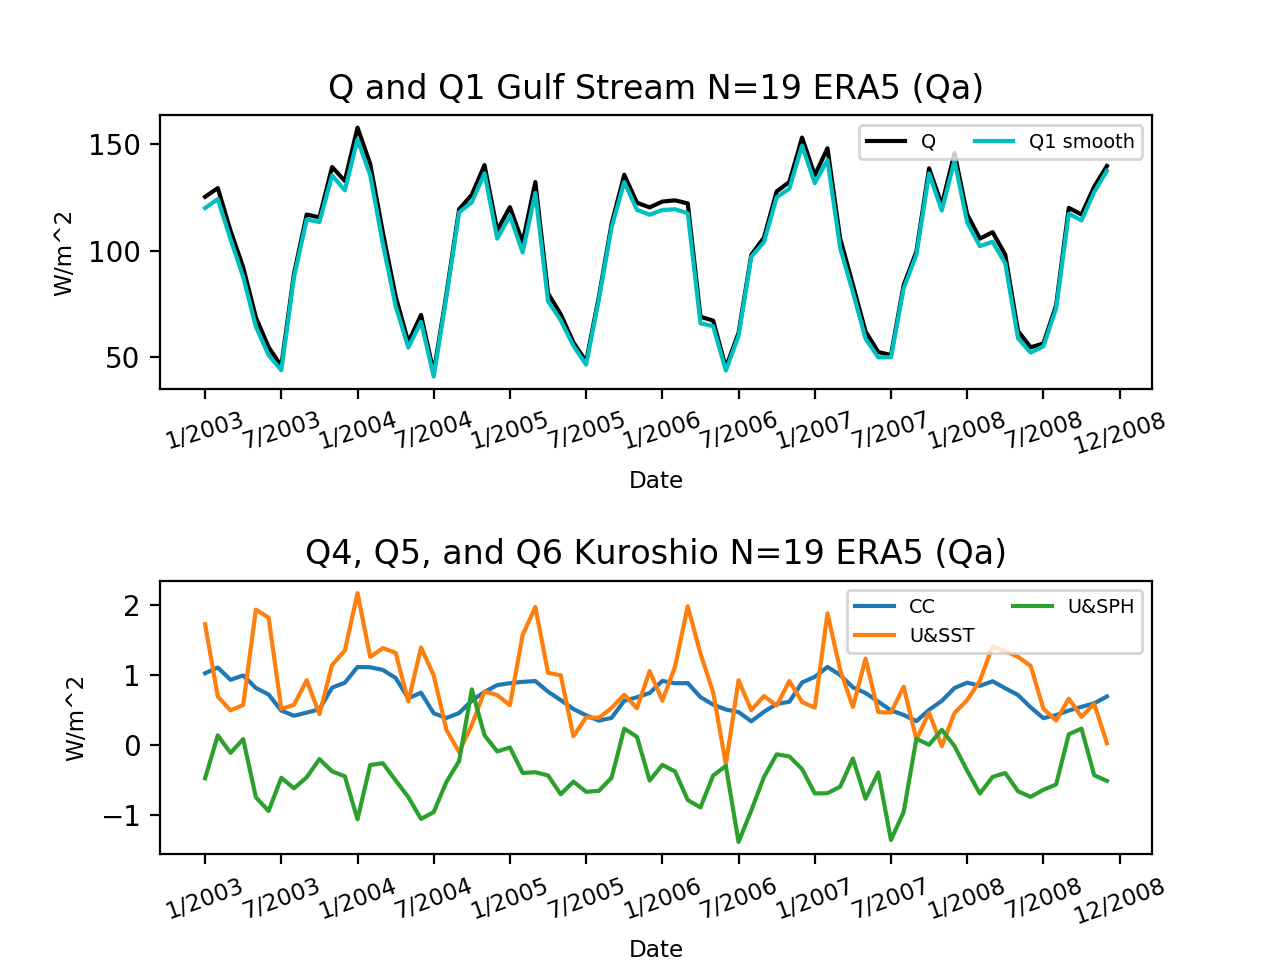

[Text(0, 0, '1/2003'),
 Text(0, 0, '7/2003'),
 Text(0, 0, '1/2004'),
 Text(0, 0, '7/2004'),
 Text(0, 0, '1/2005'),
 Text(0, 0, '7/2005'),
 Text(0, 0, '1/2006'),
 Text(0, 0, '7/2006'),
 Text(0, 0, '1/2007'),
 Text(0, 0, '7/2007'),
 Text(0, 0, '1/2008'),
 Text(0, 0, '7/2008'),
 Text(0, 0, '12/2008')]

In [105]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.7)

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

ax = axs[0]
ax.plot(m_str,Q_mmean,'k',label='Q')
ax.plot(m_str,Q1_mmean,'c',label='Q1 smooth')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Q and Q1 Gulf Stream N=19 ERA5 (Qa)')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
#ax.set_ylim([52,85])


ax = axs[1]
ax.plot(m_str,Q4_mmean,label='CC')
ax.plot(m_str,Q5_mmean,label='U&SST')
ax.plot(m_str,Q6_mmean,label='U&SPH')
ax.legend(loc='upper right',fontsize='x-small', ncol=2)
ax.set_title('Q4, Q5, and Q6 Kuroshio N=19 ERA5 (Qa)')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=20,fontsize='small')
#ax.set_ylim([-.55,.3])



<IPython.core.display.Javascript object>


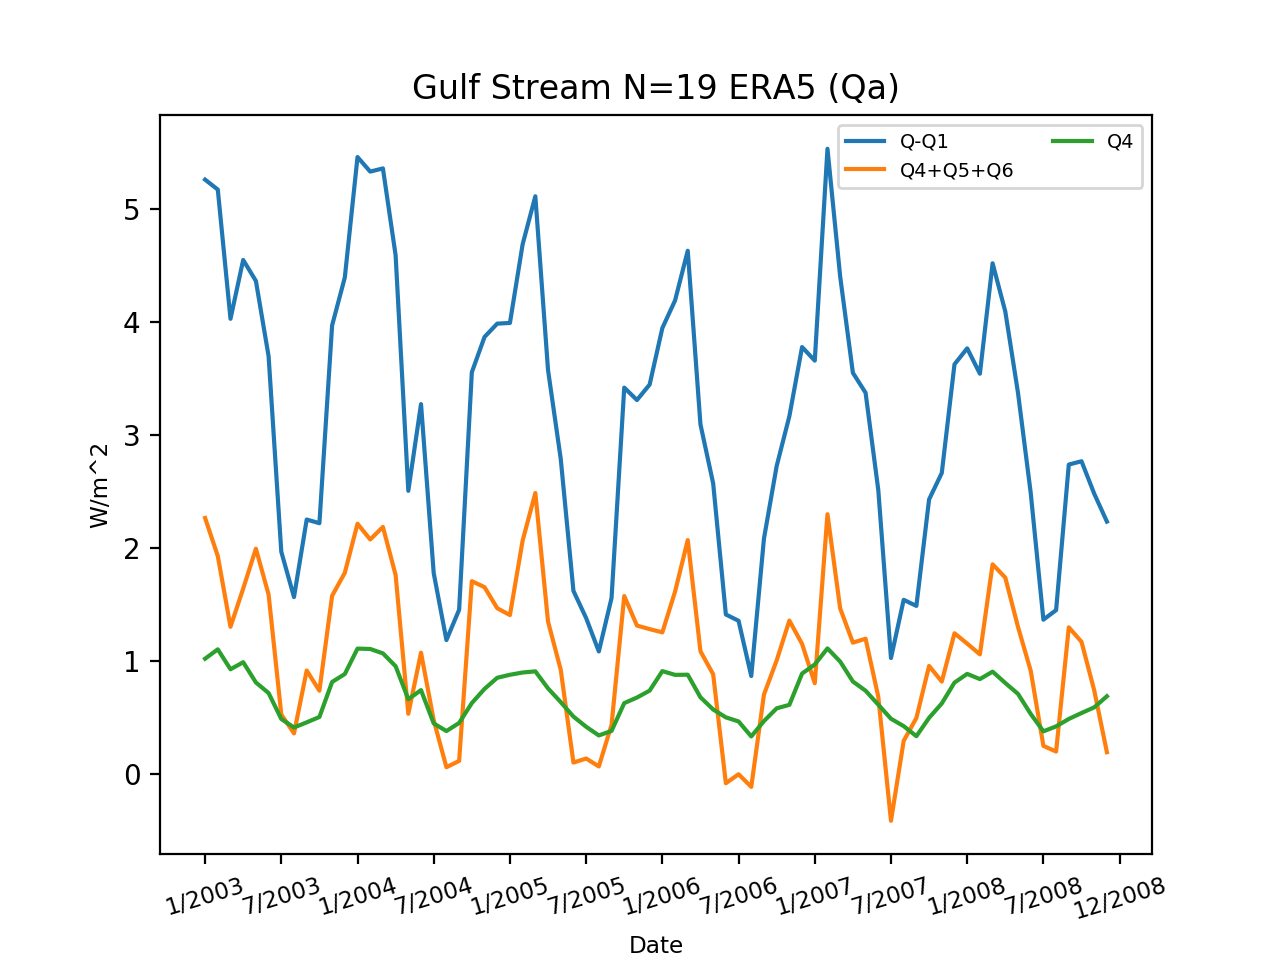

[Text(0, 0, '1/2003'),
 Text(0, 0, '7/2003'),
 Text(0, 0, '1/2004'),
 Text(0, 0, '7/2004'),
 Text(0, 0, '1/2005'),
 Text(0, 0, '7/2005'),
 Text(0, 0, '1/2006'),
 Text(0, 0, '7/2006'),
 Text(0, 0, '1/2007'),
 Text(0, 0, '7/2007'),
 Text(0, 0, '1/2008'),
 Text(0, 0, '7/2008'),
 Text(0, 0, '12/2008')]

In [106]:
fig, axs = plt.subplots()
fig.subplots_adjust()

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

r = np.add(Q4_mmean,Q5_mmean)
w = np.add(r,Q6_mmean)

axs.plot(m_str,np.subtract(Q_mmean,Q1_mmean),label='Q-Q1')
axs.plot(m_str,w,label='Q4+Q5+Q6')
axs.plot(m_str,Q4_mmean,label='Q4')
axs.legend(loc='upper right', fontsize='x-small', ncol=2)
axs.set_title('Gulf Stream N=19 ERA5 (Qa)')
axs.set_ylabel('W/m^2',fontsize='small')
axs.set_xlabel('Date',fontsize='small')
axs.set_xticks(i)
axs.set_xticklabels(m_str_short, rotation=17,fontsize='small')


<IPython.core.display.Javascript object>


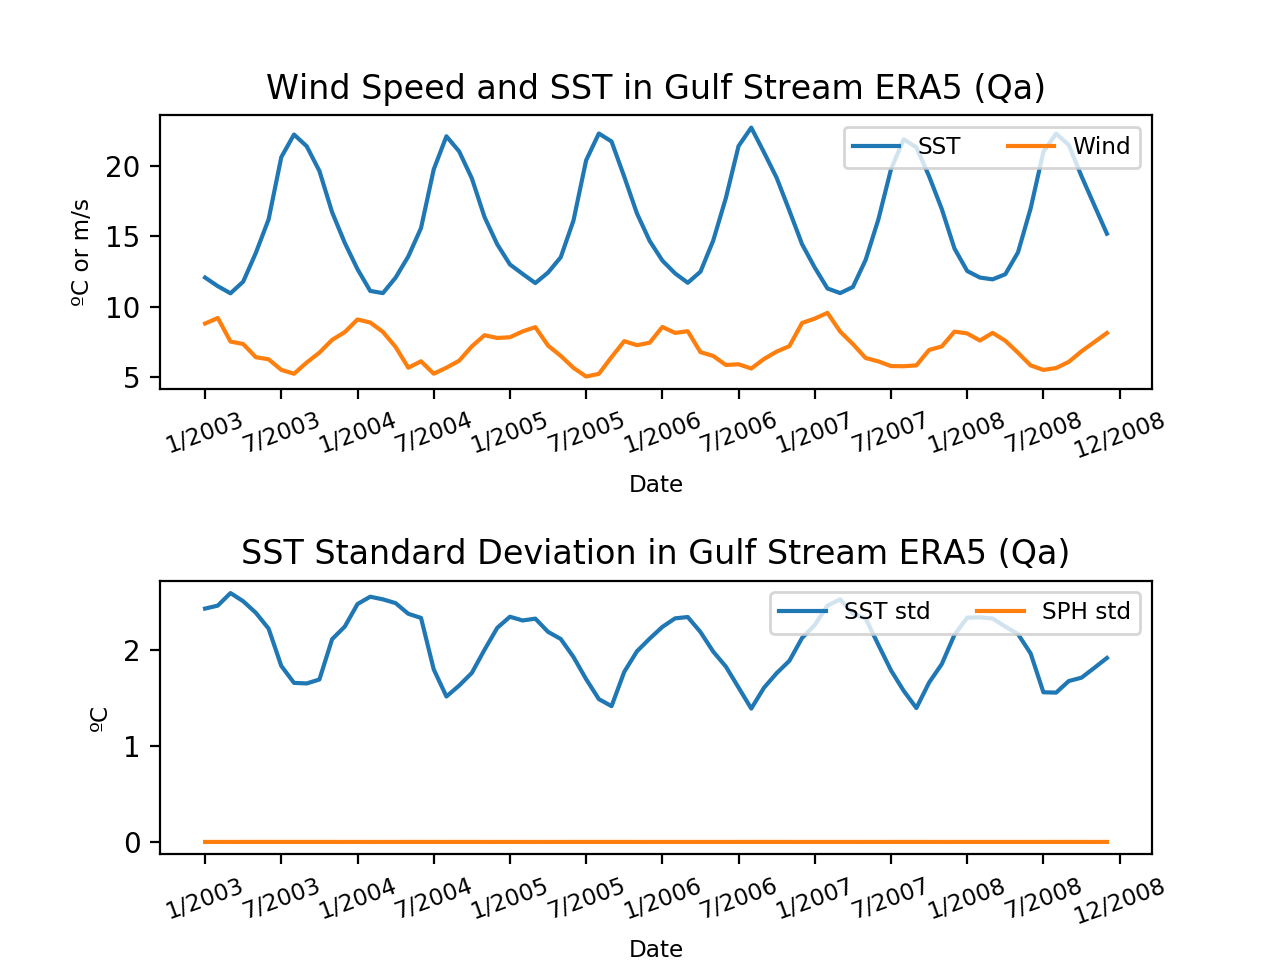

[Text(0, 0, '1/2003'),
 Text(0, 0, '7/2003'),
 Text(0, 0, '1/2004'),
 Text(0, 0, '7/2004'),
 Text(0, 0, '1/2005'),
 Text(0, 0, '7/2005'),
 Text(0, 0, '1/2006'),
 Text(0, 0, '7/2006'),
 Text(0, 0, '1/2007'),
 Text(0, 0, '7/2007'),
 Text(0, 0, '1/2008'),
 Text(0, 0, '7/2008'),
 Text(0, 0, '12/2008')]

In [109]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.7)

ax = axs[0]
ax.plot(m_str,sst_mmean,label='SST')
ax.plot(m_str,wspd_mmean,label='Wind')
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_ylabel('ºC or m/s',fontsize='small')
ax.set_title('Wind Speed and SST in Gulf Stream ERA5 (Qa)')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=20,fontsize='small')
#ax.set_ylim([6,16])

ax = axs[1]
ax.plot(m_str,sst_std_mmean,label="SST std")
ax.plot(m_str,qa_std_mmean,label="SPH std")
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('SST Standard Deviation in Gulf Stream ERA5 (Qa)')
ax.set_ylabel('ºC',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=20,fontsize='small')


In [107]:
#take seasonal averages
sst_DJF, sst_MAM, sst_JJA, sst_SON = seasonal_avg(sst,ym)
wspd_DJF, wspd_MAM, wspd_JJA, wspd_SON = seasonal_avg(wspd,ym)
Q_DJF, Q_MAM, Q_JJA, Q_SON = seasonal_avg(Q,ym)
Q1_DJF, Q1_MAM, Q1_JJA, Q1_SON = seasonal_avg(Q1,ym)
Q4_DJF, Q4_MAM, Q4_JJA, Q4_SON = seasonal_avg(Q4,ym)
Q5_DJF, Q5_MAM, Q5_JJA, Q5_SON = seasonal_avg(Q5,ym)
Q6_DJF, Q6_MAM, Q6_JJA, Q6_SON = seasonal_avg(Q6,ym)
sst_std_DJF, sst_std_MAM, sst_std_JJA, sst_std_SON = seasonal_avg(sst_std,ym)
qa_std_DJF, qa_std_MAM, qa_std_JJA, qa_std_SON = seasonal_avg(qa_std,ym)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


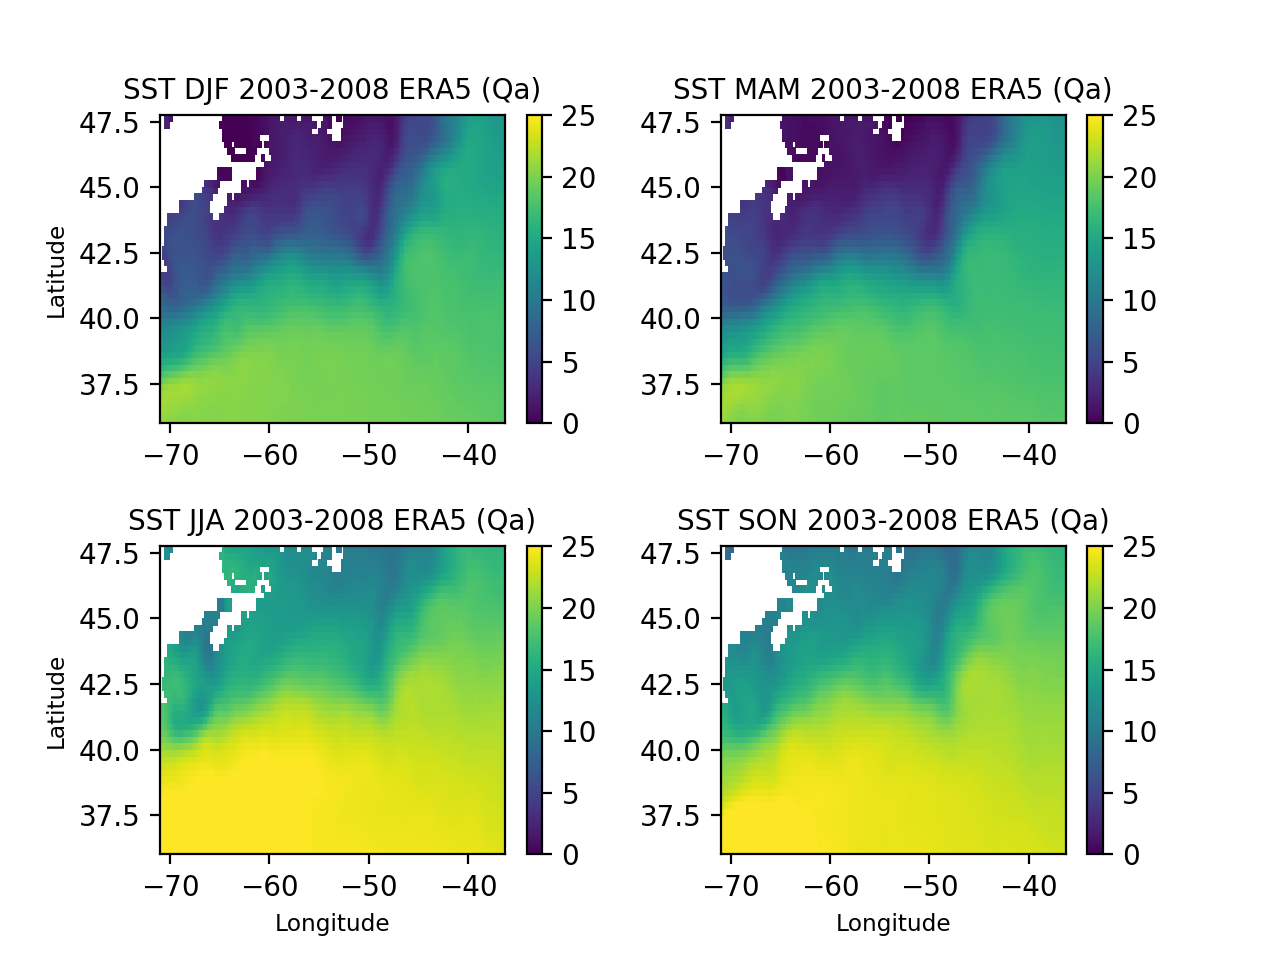

Text(0.5, 1.0, 'SST SON 2003-2008 ERA5 (Qa)')

In [108]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,sst_DJF,vmin=0,vmax=25)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SST DJF 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,sst_MAM,vmin=0,vmax=25)
fig.colorbar(pc,ax=ax)
ax.set_title('SST MAM 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,sst_JJA,vmin=0,vmax=25)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('SST JJA 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,sst_SON,vmin=0,vmax=25)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('SST SON 2003-2008 ERA5 (Qa)',fontsize='medium')

<IPython.core.display.Javascript object>


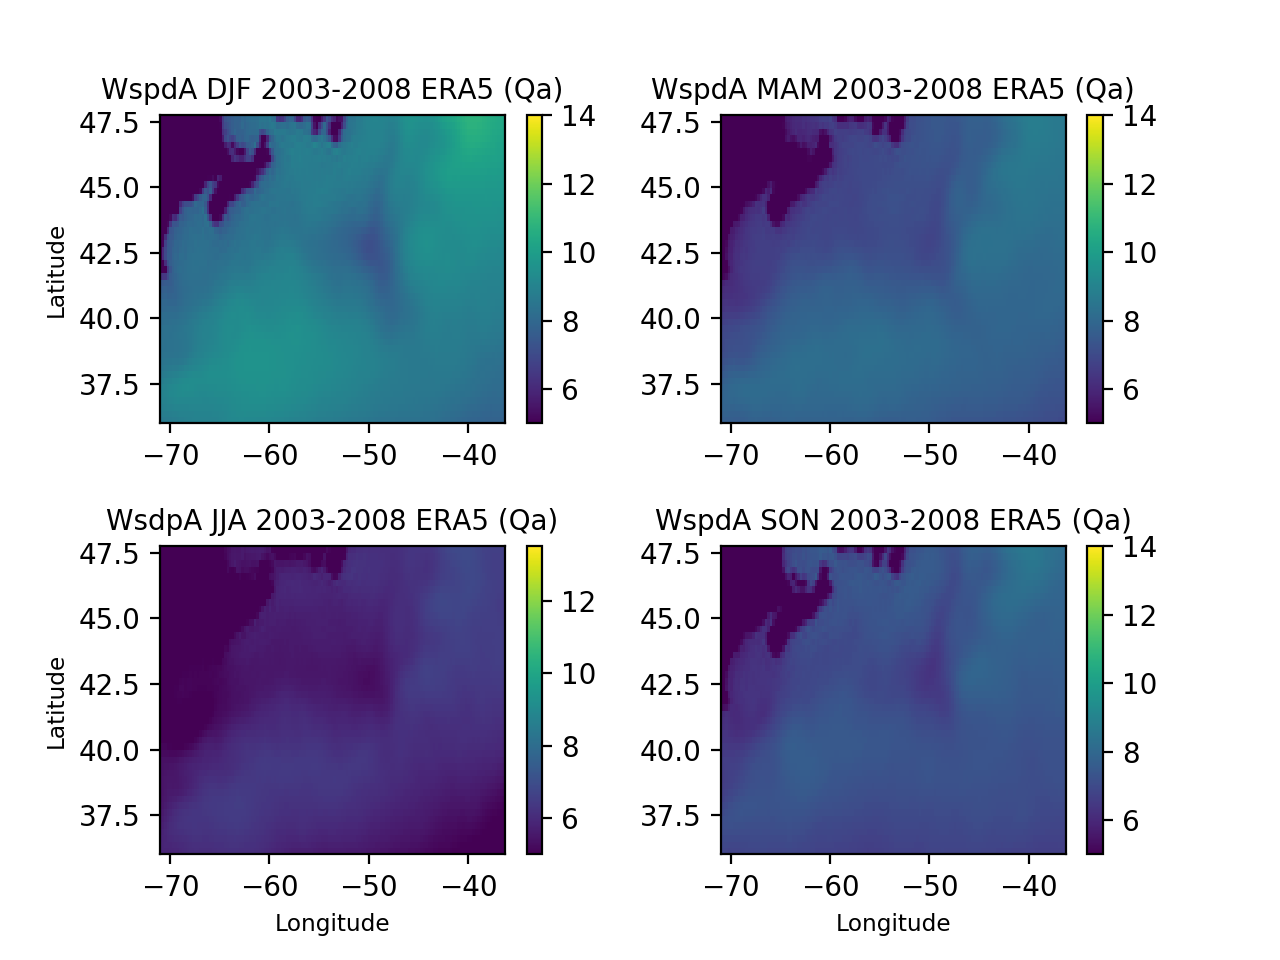

Text(0.5, 1.0, 'WspdA SON 2003-2008 ERA5 (Qa)')

In [110]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,wspd_DJF,vmin=5,vmax=14)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('WspdA DJF 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,wspd_MAM,vmin=5,vmax=14)
fig.colorbar(pc,ax=ax)
ax.set_title('WspdA MAM 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,wspd_JJA,vmin=5,vmax=13.5)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('WsdpA JJA 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,wspd_SON,vmin=5,vmax=14)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('WspdA SON 2003-2008 ERA5 (Qa)',fontsize='medium')

In [111]:
#high passs filtered sst and wspd
sstHP = np.subtract(sst,sstsm)
sstHP_DJF, sstHP_MAM, sstHP_JJA, sstHP_SON = seasonal_avg(sstHP,ym)

wspdHP = np.subtract(wspd,wspdsm)
wspdHP_DJF, wspdHP_MAM, wspdHP_JJA, wspdHP_SON = seasonal_avg(wspdHP,ym)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


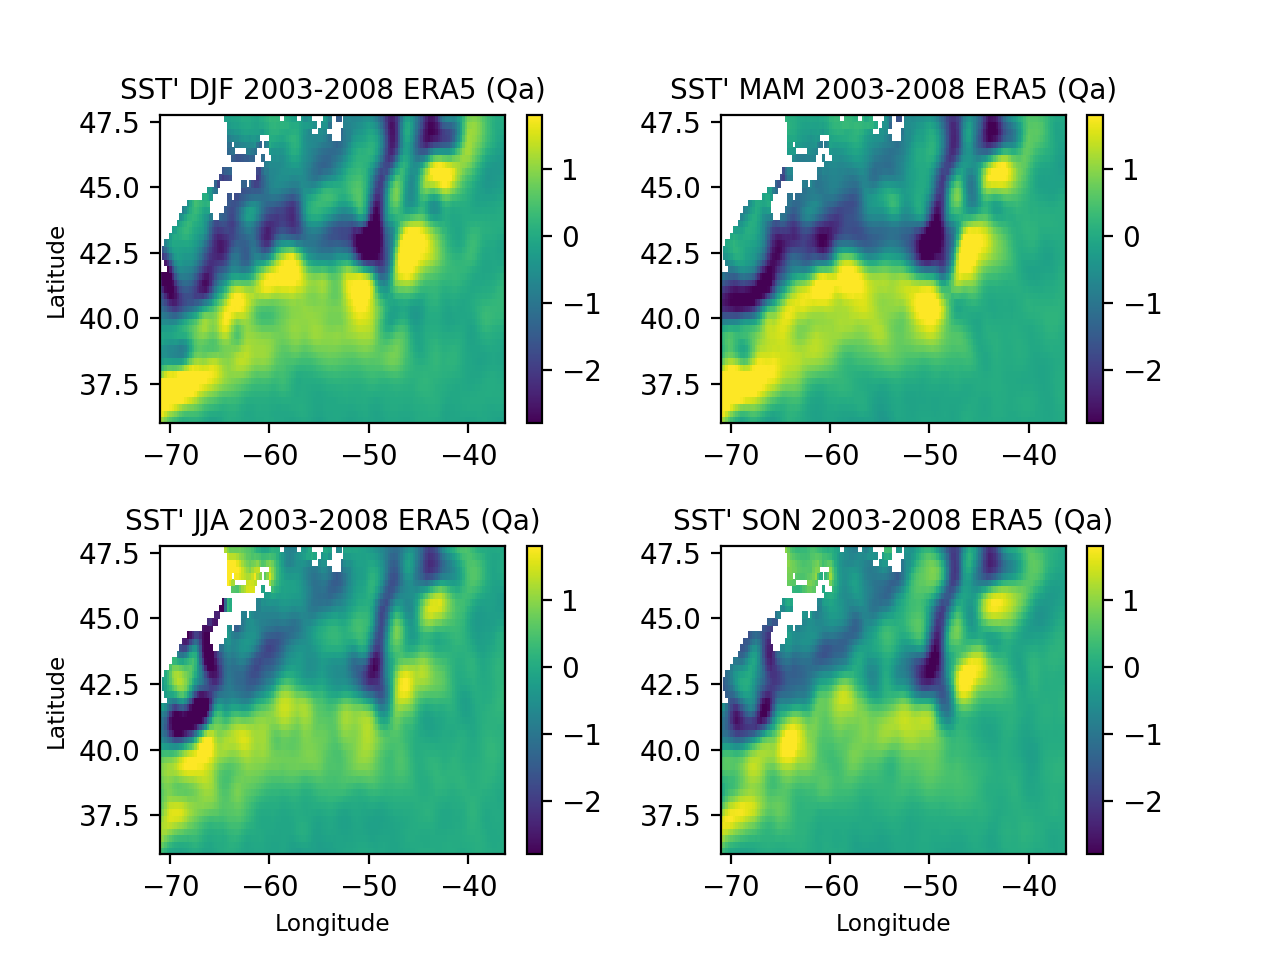

Text(0.5, 1.0, "SST' SON 2003-2008 ERA5 (Qa)")

In [112]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,sstHP_DJF,vmin=-2.8, vmax=1.8)
fig.colorbar(pc,ax=ax)
ax.set_title('Averaged')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("SST' DJF 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,sstHP_MAM,vmin=-2.8,vmax=1.8)
fig.colorbar(pc,ax=ax)
ax.set_title("SST' MAM 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,sstHP_JJA,vmin=-2.8,vmax=1.8)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("SST' JJA 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,sstHP_SON,vmin=-2.8,vmax=1.8)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("SST' SON 2003-2008 ERA5 (Qa)",fontsize='medium')

<IPython.core.display.Javascript object>


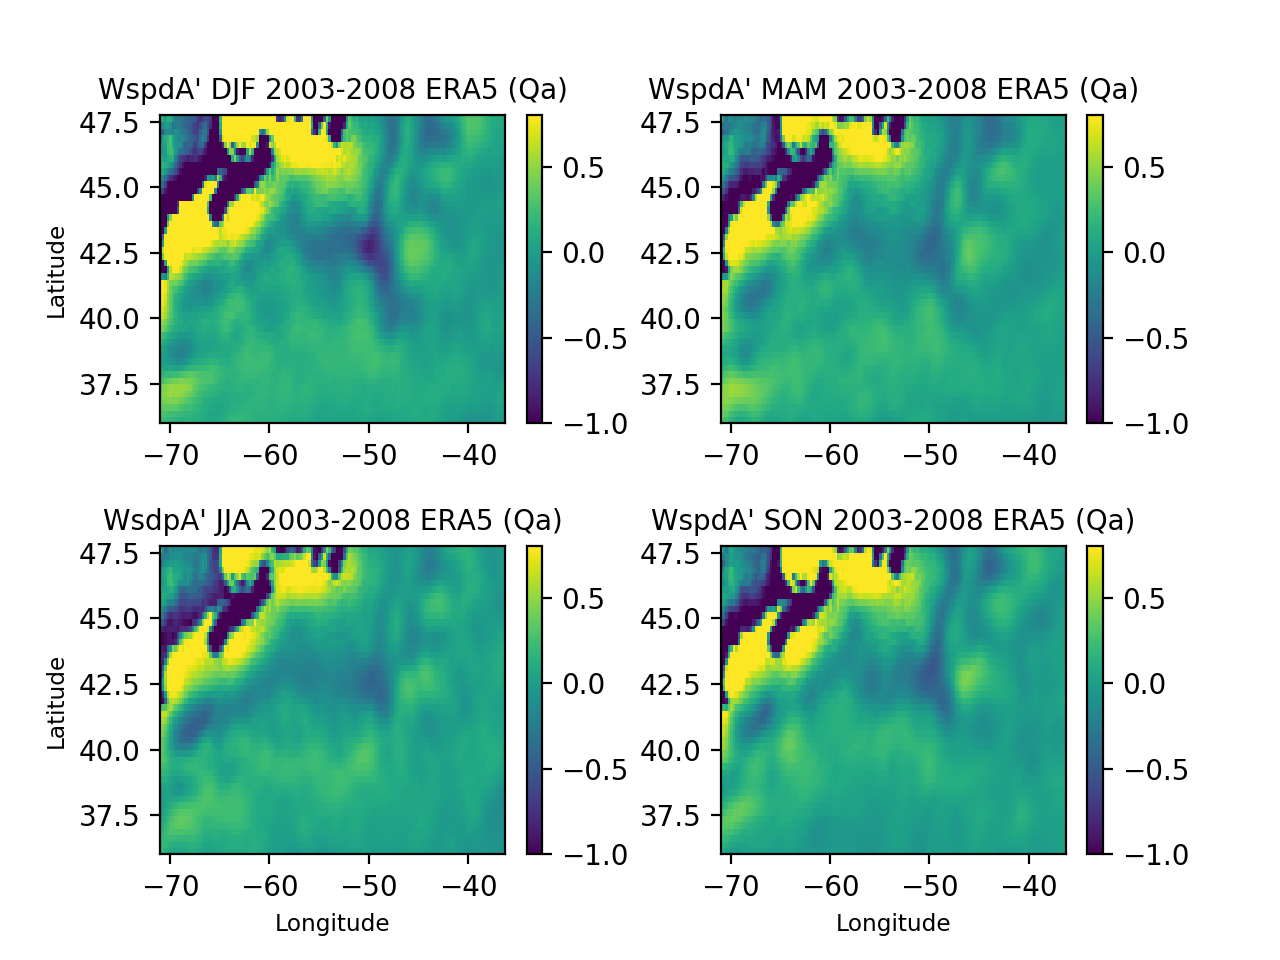

Text(0.5, 1.0, "WspdA' SON 2003-2008 ERA5 (Qa)")

In [113]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,wspdHP_DJF,vmin=-1,vmax=.8)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("WspdA' DJF 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,wspdHP_MAM,vmin=-1,vmax=.8)
fig.colorbar(pc,ax=ax)
ax.set_title("WspdA' MAM 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,wspdHP_JJA,vmin=-1,vmax=.8)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title("WsdpA' JJA 2003-2008 ERA5 (Qa)",fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,wspdHP_SON,vmin=-1,vmax=.8)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title("WspdA' SON 2003-2008 ERA5 (Qa)",fontsize='medium')

In [114]:
#averge all time together to get map
Qmean = np.nanmean(Q,axis=0)
QHP = np.subtract(Q,Q1)
QHPmean = np.nanmean(QHP,axis=0)
Q4mean = np.nanmean(Q4,axis=0)
Q5mean = np.nanmean(Q5,axis=0)
Q6mean = np.nanmean(Q6,axis=0)


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


<IPython.core.display.Javascript object>


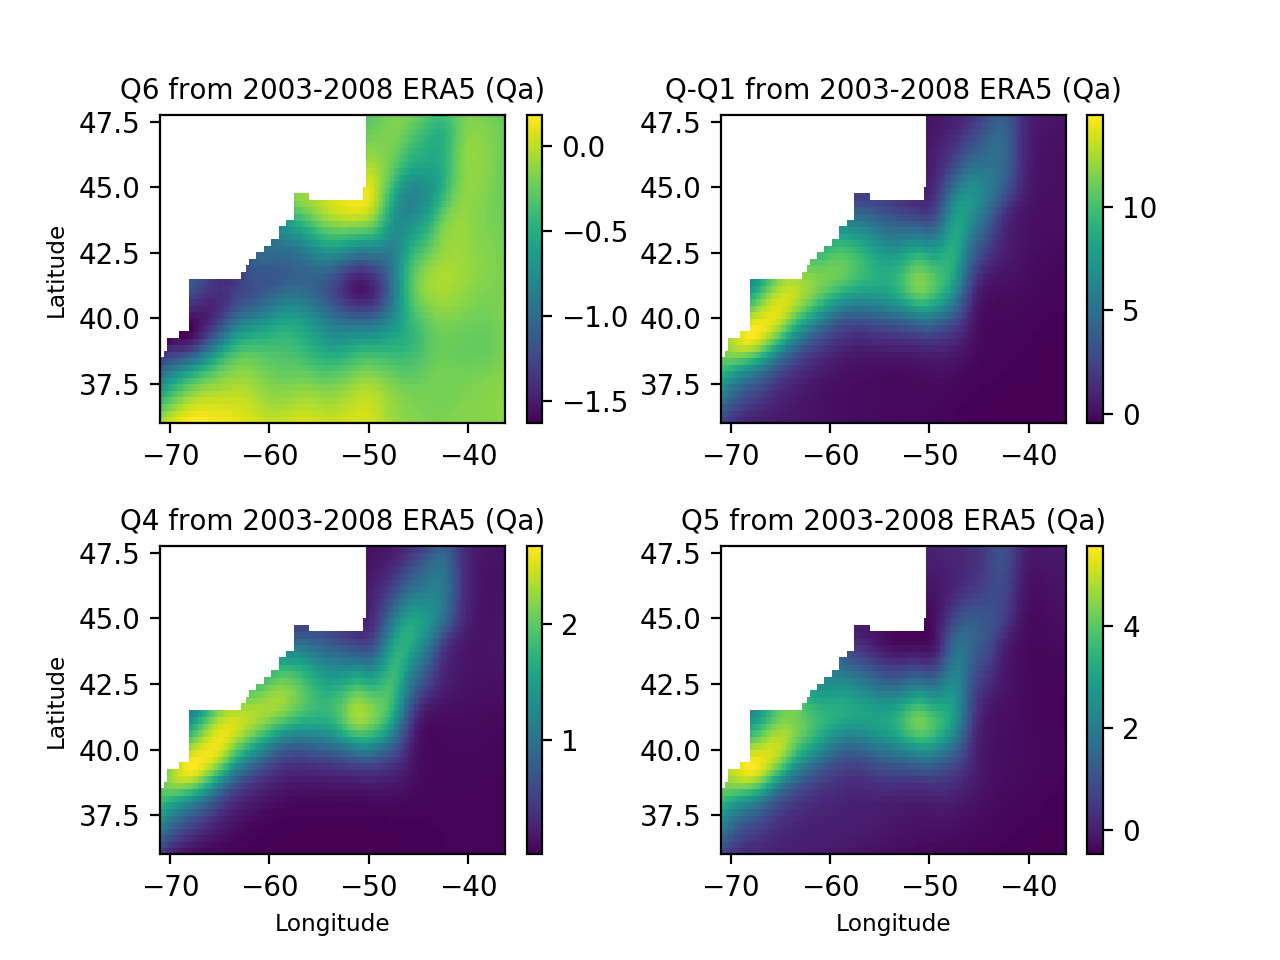

Text(0.5, 0, 'Longitude')

In [115]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=0.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,Q6mean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q6 from 2003-2008 ERA5 (Qa)',fontsize='medium')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,QHPmean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q-Q1 from 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,Q4mean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q4 from 2003-2008 ERA5 (Qa)',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,Q5mean)
fig.colorbar(pc,ax=ax)
ax.set_title('Q5 from 2003-2008 ERA5 (Qa)',fontsize='medium')
ax.set_xlabel('Longitude',fontsize='small')


<IPython.core.display.Javascript object>


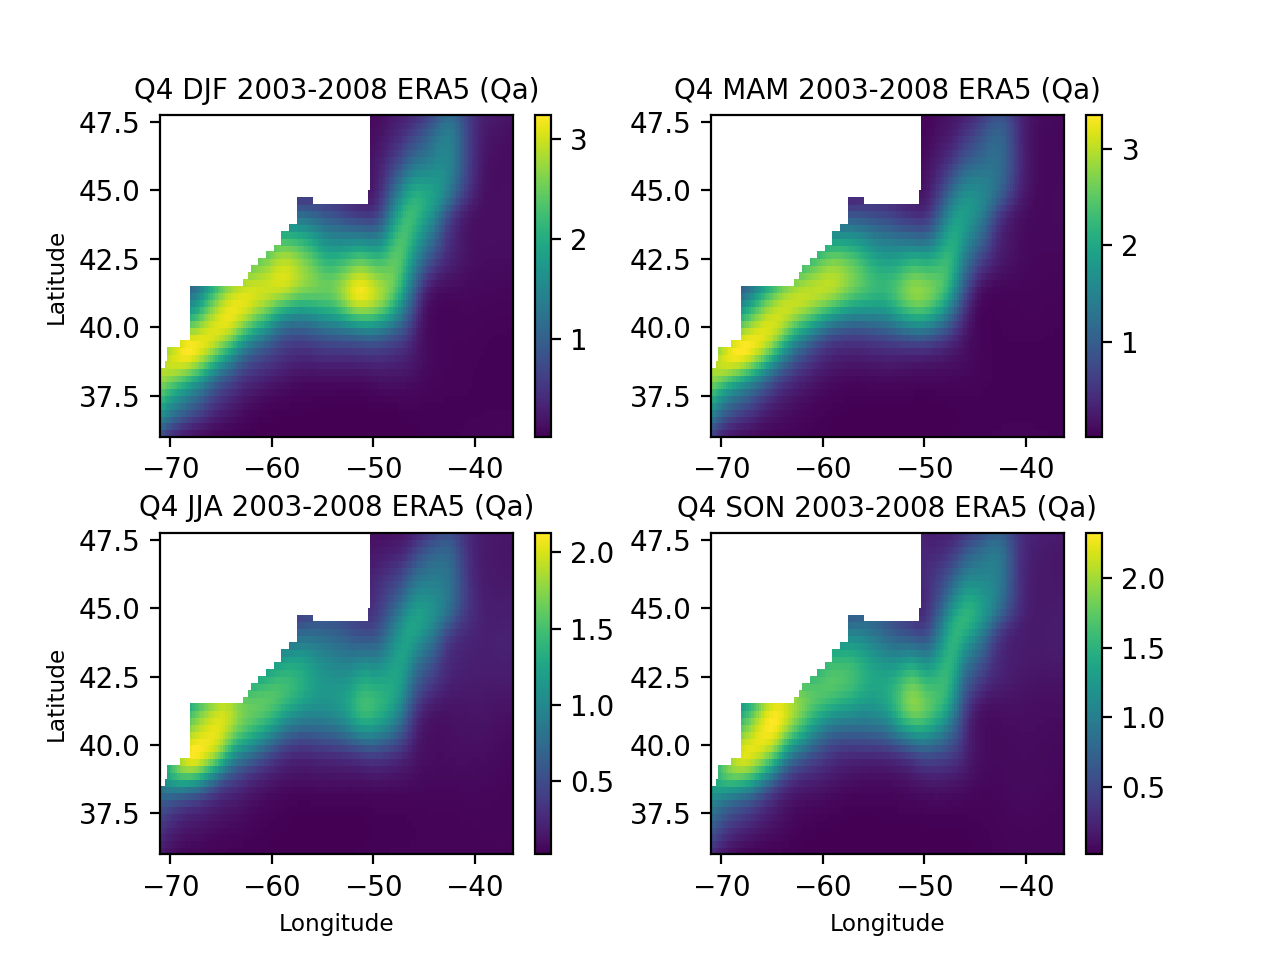

Text(0.5, 1.0, 'Q4 SON 2003-2008 ERA5 (Qa)')

In [117]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.3,wspace=.25)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,Q4_DJF)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q4 DJF 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,Q4_MAM)
fig.colorbar(pc,ax=ax)
ax.set_title('Q4 MAM 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,Q4_JJA)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q4 JJA 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,Q4_SON)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q4 SON 2003-2008 ERA5 (Qa)',fontsize='medium')

<IPython.core.display.Javascript object>


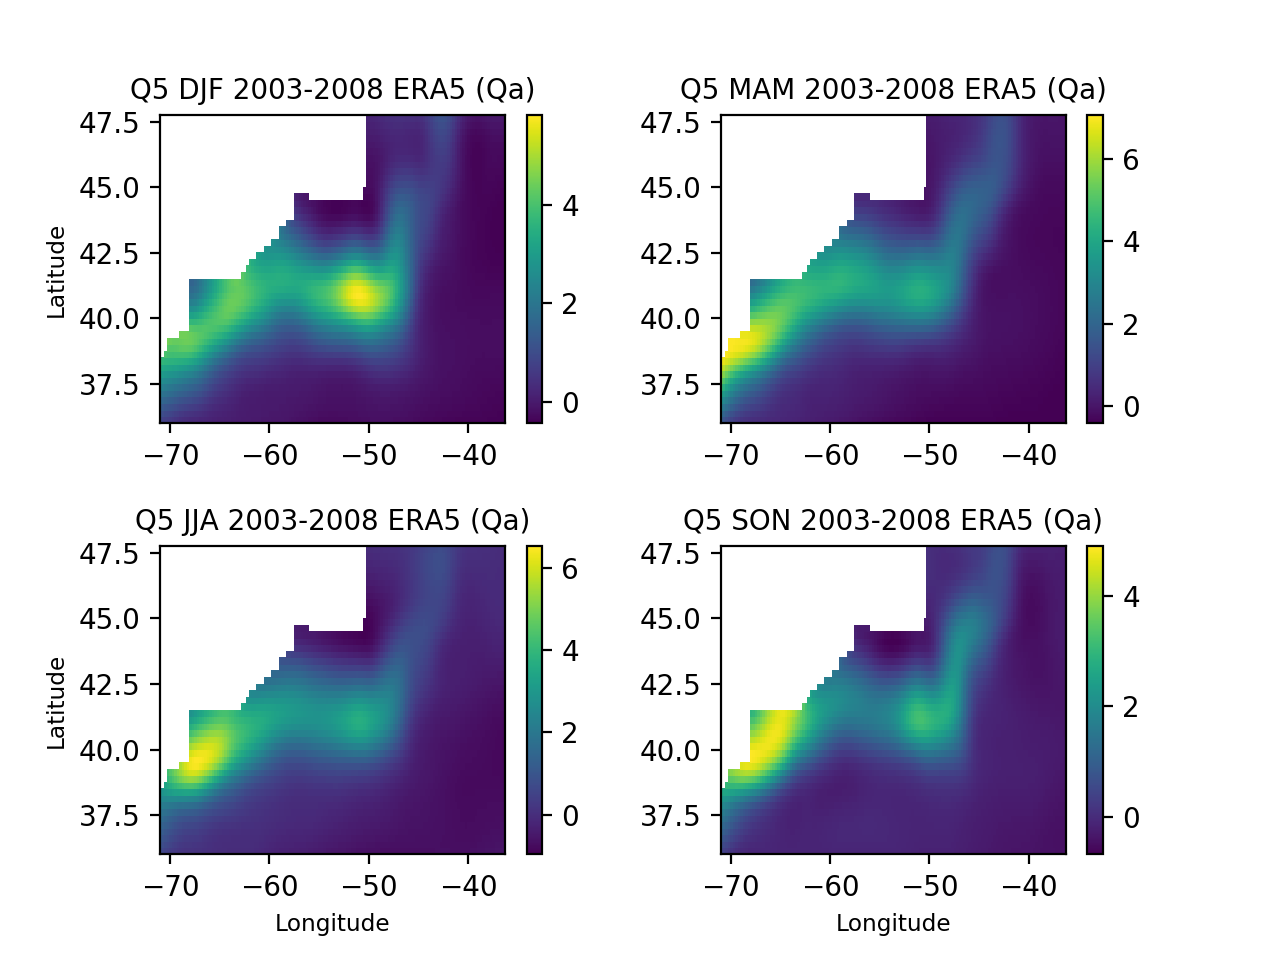

Text(0.5, 1.0, 'Q5 SON 2003-2008 ERA5 (Qa)')

In [118]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,Q5_DJF)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q5 DJF 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,Q5_MAM)
fig.colorbar(pc,ax=ax)
ax.set_title('Q5 MAM 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,Q5_JJA)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q5 JJA 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,Q5_SON)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q5 SON 2003-2008 ERA5 (Qa)',fontsize='medium')

<IPython.core.display.Javascript object>


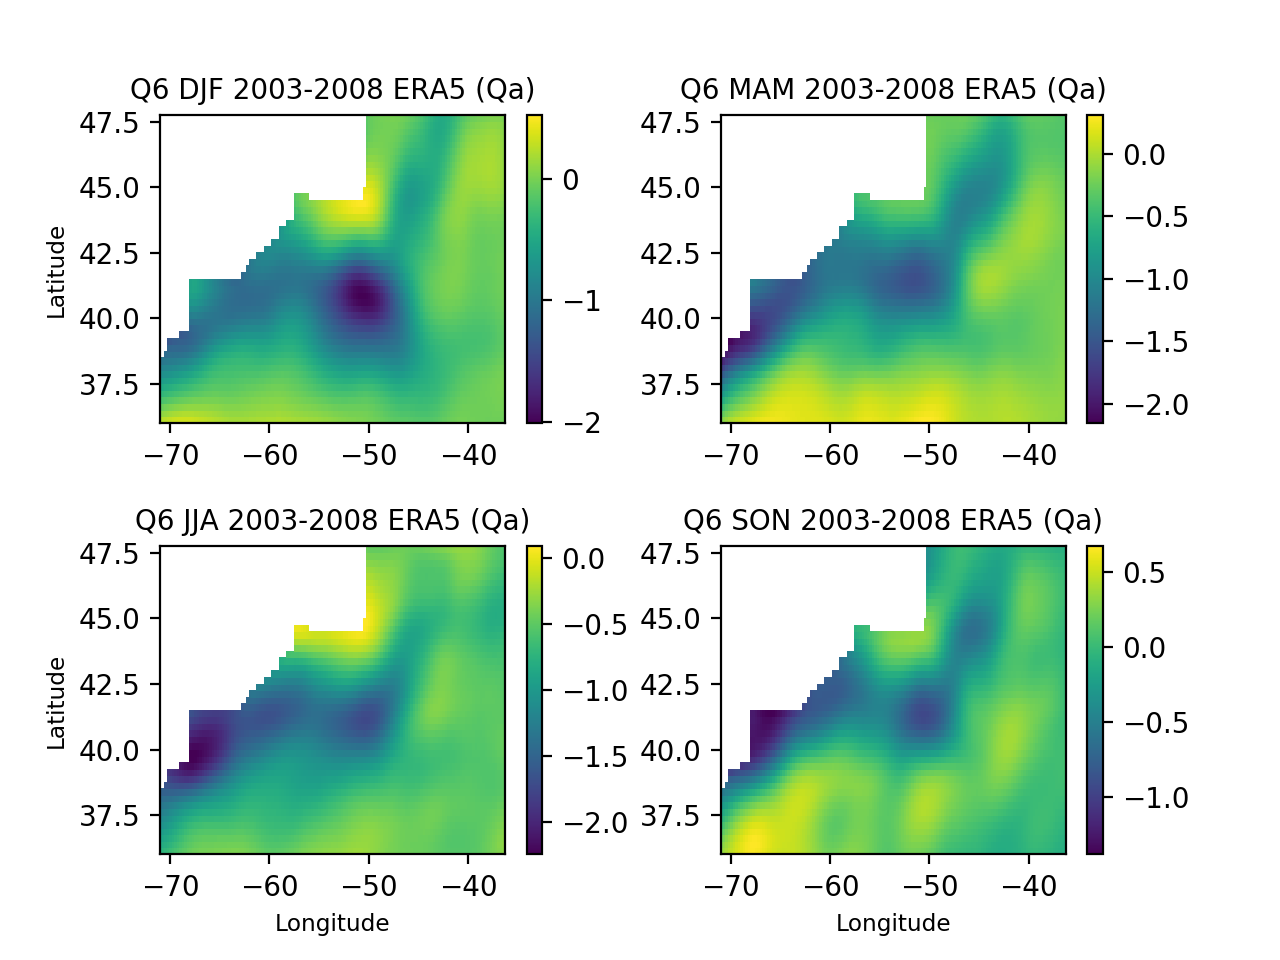

Text(0.5, 1.0, 'Q6 SON 2003-2008 ERA5 (Qa)')

In [119]:
fig, axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.4,wspace=.3)

ax = axs[0,0]
pc = ax.pcolormesh(lon,lat,Q6_DJF)
fig.colorbar(pc,ax=ax)
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q6 DJF 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[0,1]
pc = ax.pcolormesh(lon,lat,Q6_MAM)
fig.colorbar(pc,ax=ax)
ax.set_title('Q6 MAM 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,0]
pc = ax.pcolormesh(lon,lat,Q6_JJA)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_ylabel('Latitude',fontsize='small')
ax.set_title('Q6 JJA 2003-2008 ERA5 (Qa)',fontsize='medium')

ax = axs[1,1]
pc = ax.pcolormesh(lon,lat,Q6_SON)
fig.colorbar(pc,ax=ax)
ax.set_xlabel('Longitude',fontsize='small')
ax.set_title('Q6 SON 2003-2008 ERA5 (Qa)',fontsize='medium')

In [92]:
y = np.nanmean(Q_A,axis=(1,2))
y1 = np.nanmean(Q1_A,axis=(1,2))
y2 = np.nanmean(Q2_A,axis=(1,2))
y3 = np.nanmean(Q3_A,axis=(1,2))
y4 = np.nanmean(Q4_A,axis=(1,2))
y5 = np.nanmean(Q5_A,axis=(1,2))
y6 = np.nanmean(stdA,axis=(1,2))
ydiff = y - y1
ydiff2 = y4 + y5
print(y.shape)
print(len(time))

NameError: name 'Q2_A' is not defined

In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.7)

ax = axs[0]
ax.plot(time,ydiff,'p',label='Q')
ax.plot(time,ydiff2,'r',label='Q1 smooth')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Latent Heat: Q & Q1')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(time,y4,'k',label='CC')
ax.plot(time,y5,'c',label='U&SST')
ax.legend(loc='upper right', fontsize='x-small', ncol=2)
ax.set_title('Latent Heat: Nonlinear Contributions')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')


In [147]:
#QuikScat and ASMRE Data (S for satellite)
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/GulfStreamN19A.nc','r')
grp = f.groups['Regional_data']
print(f)
lon = grp.variables['Longitude'][:]
lat = grp.variables['Latitude'][:]
Q_S = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_S = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_S = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_S = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
sst_std_S = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

#ERA5 but NO Qa
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/GulfStreamN19.nc','r')
grp = f.groups['Regional_data']
print(f)
Q_ERA = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_ERA = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_ERA = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_ERA = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
sst_std_ERA = grp.variables['Standard Deviation of Sea Surface Temperature'][:,:,:]
f.close()

#ERA5 with Qa
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/GulfStreamN19Qa.nc','r')
grp = f.groups['Regional_data']
print(f)
Q_ERAQ = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_ERAQ = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_ERAQ = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_ERAQ = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_ERAQ = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
sst_std_ERAQ = grp.variables['Standard Deviation of SST'][:,:,:]
f.close()


time = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
_, ym, _ = monthly_avg(Q, time)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Gulf Stream; N = 19; Time = 2003/01/01 - 2008/12/31; Wind Ascending
    dimensions(sizes): 
    variables(dimensions): 
    groups: Regional_data
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Gulf Stream; N = 19; Time = 2003/01/01 - 2008/12/31; ERA5
    dimensions(sizes): 
    variables(dimensions): 
    groups: Regional_data
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Region = Gulf Stream; N = 19; Time = 2003/01/01 - 2008/12/31; ERA5 Qa
    dimensions(sizes): 
    variables(dimensions): 
    groups: Regional_data


In [155]:
print(np.nanmax(Q4_S))
print(np.nanmin(Q4_S))


print('U & SST max: ',np.nanmax(Q5_S))
print('U & SST min: ',np.nanmin(Q5_S))


15.364373
0.0011213709
U & SST max:  22.195667
U & SST min:  -15.616248


<IPython.core.display.Javascript object>


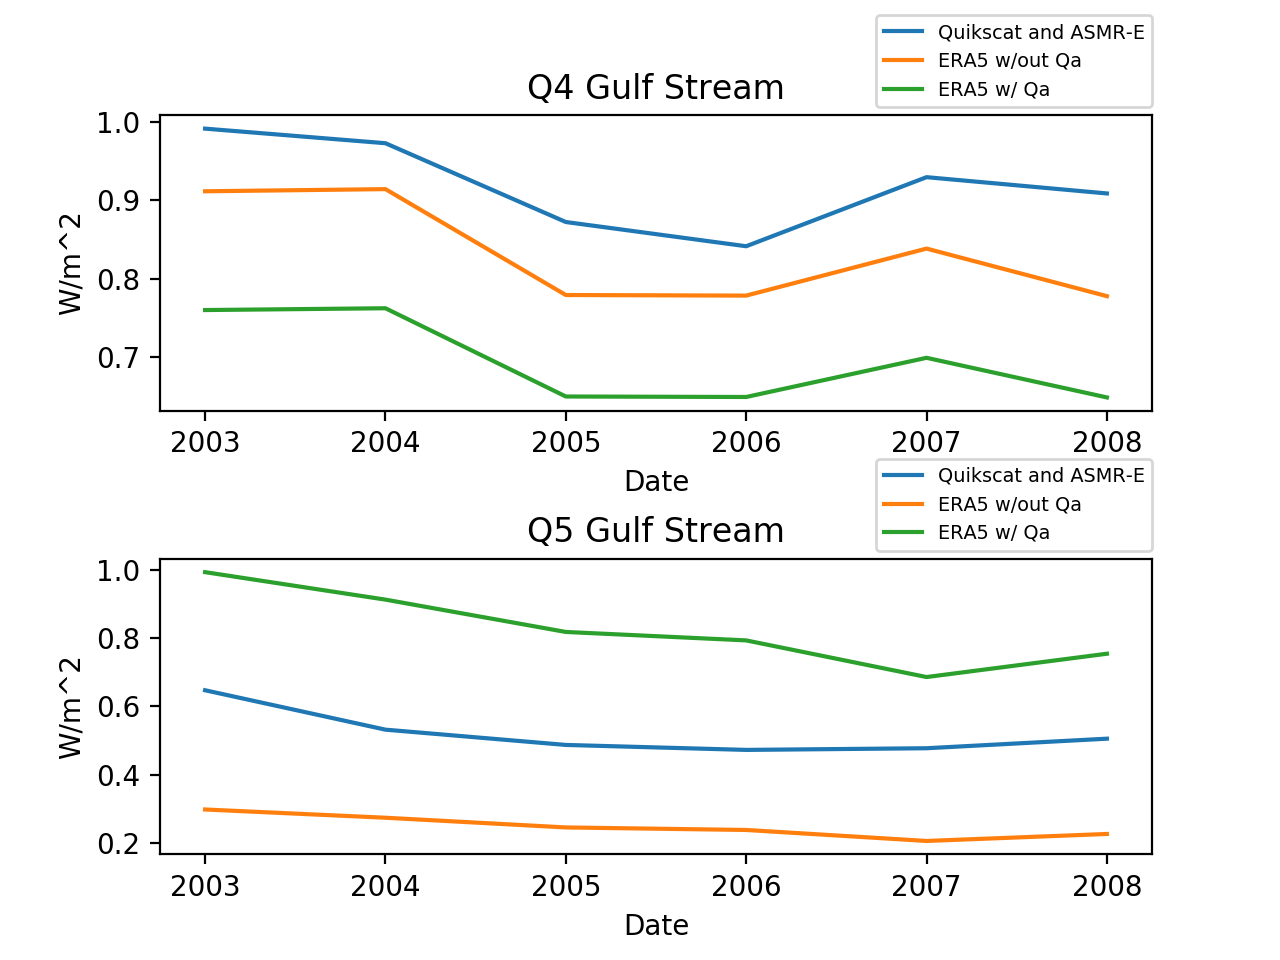

Text(0.5, 0, 'Date')

In [148]:
Q4_S_avg,y = annual_avg(Q4_S,ym,dimension="1D")
Q4_ERA_avg,_ = annual_avg(Q4_ERA,ym,dimension="1D")
Q4_ERAQ_avg,_ = annual_avg(Q4_ERAQ,ym,dimension="1D")

Q5_S_avg,y = annual_avg(Q5_S,ym,dimension="1D")
Q5_ERA_avg,_ = annual_avg(Q5_ERA,ym,dimension="1D")
Q5_ERAQ_avg,_ = annual_avg(Q5_ERAQ,ym,dimension="1D")


fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_S_avg,label='Quikscat and ASMR-E')
ax.plot(y,Q4_ERA_avg,label='ERA5 w/out Qa')
ax.plot(y,Q4_ERAQ_avg,label='ERA5 w/ Qa')
ax.legend(bbox_to_anchor=(1.01, 1.37),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Gulf Stream')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_S_avg,label='Quikscat and ASMR-E')
ax.plot(y,Q5_ERA_avg,label='ERA5 w/out Qa')
ax.plot(y,Q5_ERAQ_avg,label='ERA5 w/ Qa')
ax.legend(bbox_to_anchor=(1.01, 1.37),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Gulf Stream')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')



In [151]:
print(m_str)
print(m_str_short)

['1/2003', '2/2003', '3/2003', '4/2003', '5/2003', '6/2003', '7/2003', '8/2003', '9/2003', '10/2003', '11/2003', '12/2003', '1/2004', '2/2004', '3/2004', '4/2004', '5/2004', '6/2004', '7/2004', '8/2004', '9/2004', '10/2004', '11/2004', '12/2004', '1/2005', '2/2005', '3/2005', '4/2005', '5/2005', '6/2005', '7/2005', '8/2005', '9/2005', '10/2005', '11/2005', '12/2005', '1/2006', '2/2006', '3/2006', '4/2006', '5/2006', '6/2006', '7/2006', '8/2006', '9/2006', '10/2006', '11/2006', '12/2006', '1/2007', '2/2007', '3/2007', '4/2007', '5/2007', '6/2007', '7/2007', '8/2007', '9/2007', '10/2007', '11/2007', '12/2007', '1/2008', '2/2008', '3/2008', '4/2008', '5/2008', '6/2008', '7/2008', '8/2008', '9/2008', '10/2008', '11/2008', '12/2008']
['1/2003', '7/2003', '1/2004', '7/2004', '1/2005', '7/2005', '1/2006', '7/2006', '1/2007', '7/2007', '1/2008', '7/2008', '12/2008']


<IPython.core.display.Javascript object>


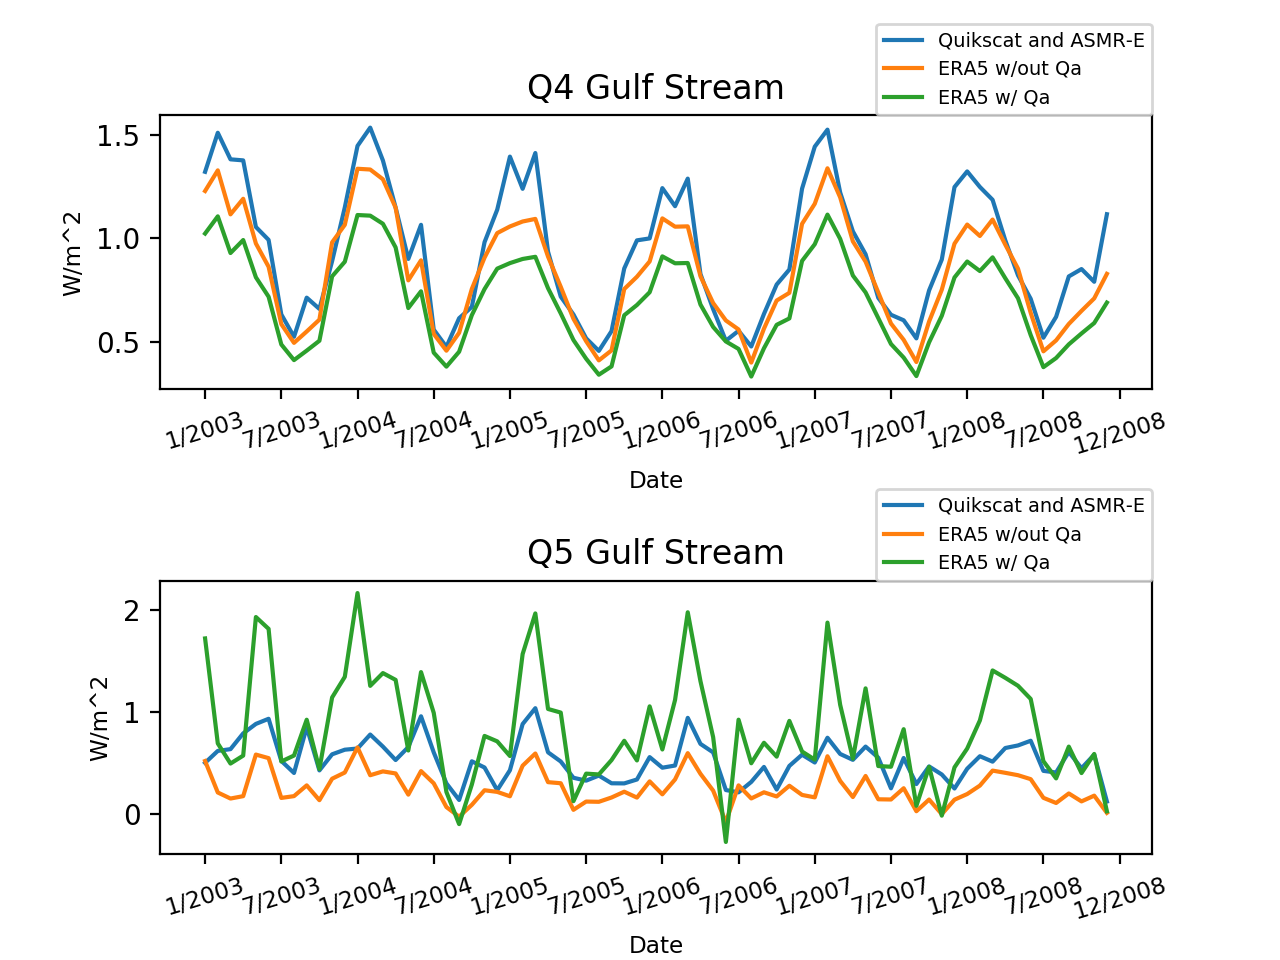

[Text(0, 0, '1/2003'),
 Text(0, 0, '7/2003'),
 Text(0, 0, '1/2004'),
 Text(0, 0, '7/2004'),
 Text(0, 0, '1/2005'),
 Text(0, 0, '7/2005'),
 Text(0, 0, '1/2006'),
 Text(0, 0, '7/2006'),
 Text(0, 0, '1/2007'),
 Text(0, 0, '7/2007'),
 Text(0, 0, '1/2008'),
 Text(0, 0, '7/2008'),
 Text(0, 0, '12/2008')]

In [149]:

Q4_S_mmean, ym, m_str = monthly_avg(Q4_S, time)
Q4_ERA_mmean, _, _ = monthly_avg(Q4_ERA, time)
Q4_ERAQ_mmean, _, _ = monthly_avg(Q4_ERAQ, time)

Q5_S_mmean, _, _ = monthly_avg(Q5_S, time)
Q5_ERA_mmean, _, _ = monthly_avg(Q5_ERA, time)
Q5_ERAQ_mmean, _, _ = monthly_avg(Q5_ERAQ, time)


fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.7)

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

ax = axs[0]
ax.plot(m_str,Q4_S_mmean,label='Quikscat and ASMR-E')
ax.plot(m_str,Q4_ERA_mmean,label='ERA5 w/out Qa')
ax.plot(m_str,Q4_ERAQ_mmean,label='ERA5 w/ Qa')
ax.legend(bbox_to_anchor=(1.01, 1.37),loc='upper right', fontsize='x-small', ncol=1)
ax.set_title('Q4 Gulf Stream')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
#ax.set_ylim([52,85])


ax = axs[1]
ax.plot(m_str,Q5_S_mmean,label='Quikscat and ASMR-E')
ax.plot(m_str,Q5_ERA_mmean,label='ERA5 w/out Qa')
ax.plot(m_str,Q5_ERAQ_mmean,label='ERA5 w/ Qa')
ax.legend(bbox_to_anchor=(1.01, 1.37),loc='upper right', fontsize='x-small', ncol=1)
ax.set_title('Q5 Gulf Stream')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')

# Filter Size

In [ ]:
f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN11.nc','r')
grp = f.groups['Regional_data']
Q4_N11=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N11=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
time = grp.variables['Time'][:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN13.nc','r')
grp = f.groups['Regional_data']
Q4_N13=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N13=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN15.nc','r')
grp = f.groups['Regional_data']
Q4_N15=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N15=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN17.nc','r')
grp = f.groups['Regional_data']
Q4_N17=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N17=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN19.nc','r')
grp = f.groups['Regional_data']
Q4_N19=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N19=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN21.nc','r')
grp = f.groups['Regional_data']
Q4_N21=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N21=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()

f = nc4.Dataset('/Users/baileydonaldson/python/ERA5/KuroshioN23.nc','r')
grp = f.groups['Regional_data']
Q4_N23=grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_N23=grp.variables['Covariability of SST and U (Q5)'][:,:,:]
f.close()



In [ ]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''   
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time

day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
_, ym, _ = monthly_avg(Q4_N11, day)


In [ ]:

Q4_N11_DJF, Q4_N11_MAM, Q4_N11_JJA, Q4_N11_SON, y = seasonal_avg2(Q4_N11,ym,dimension="1D")
Q5_N11_DJF, Q5_N11_MAM, Q5_N11_JJA, Q5_N11_SON, _ = seasonal_avg2(Q5_N11,ym,dimension="1D")

Q4_N13_DJF, Q4_N13_MAM, Q4_N13_JJA, Q4_N13_SON, _ = seasonal_avg2(Q4_N13,ym,dimension="1D")
Q5_N13_DJF, Q5_N13_MAM, Q5_N13_JJA, Q5_N13_SON, _ = seasonal_avg2(Q5_N13,ym,dimension="1D")

Q4_N15_DJF, Q4_N15_MAM, Q4_N15_JJA, Q4_N15_SON, _ = seasonal_avg2(Q4_N15,ym,dimension="1D")
Q5_N15_DJF, Q5_N15_MAM, Q5_N15_JJA, Q5_N15_SON, _ = seasonal_avg2(Q5_N15,ym,dimension="1D")

Q4_N17_DJF, Q4_N17_MAM, Q4_N17_JJA, Q4_N17_SON, _ = seasonal_avg2(Q4_N17,ym,dimension="1D")
Q5_N17_DJF, Q5_N17_MAM, Q5_N17_JJA, Q5_N17_SON, _ = seasonal_avg2(Q5_N17,ym,dimension="1D")

Q4_N19_DJF, Q4_N19_MAM, Q4_N19_JJA, Q4_N19_SON, _ = seasonal_avg2(Q4_N19,ym,dimension="1D")
Q5_N19_DJF, Q5_N19_MAM, Q5_N19_JJA, Q5_N19_SON, _ = seasonal_avg2(Q5_N19,ym,dimension="1D")

Q4_N21_DJF, Q4_N21_MAM, Q4_N21_JJA, Q4_N21_SON, _ = seasonal_avg2(Q4_N21,ym,dimension="1D")
Q5_N21_DJF, Q5_N21_MAM, Q5_N21_JJA, Q5_N21_SON, _ = seasonal_avg2(Q5_N21,ym,dimension="1D")

Q4_N23_DJF, Q4_N23_MAM, Q4_N23_JJA, Q4_N23_SON, _ = seasonal_avg2(Q4_N23,ym,dimension="1D")
Q5_N23_DJF, Q5_N23_MAM, Q5_N23_JJA, Q5_N23_SON, _ = seasonal_avg2(Q5_N23,ym,dimension="1D")

In [ ]:
Q4_N11_avg,y = annual_avg(Q4_N11,ym,dimension="1D")
Q5_N11_avg,_ = annual_avg(Q5_N11,ym,dimension="1D")

Q4_N13_avg,_ = annual_avg(Q4_N13,ym,dimension="1D")
Q5_N13_avg,_ = annual_avg(Q5_N13,ym,dimension="1D")

Q4_N15_avg,_ = annual_avg(Q4_N15,ym,dimension="1D")
Q5_N15_avg,_ = annual_avg(Q5_N15,ym,dimension="1D")

Q4_N17_avg,_ = annual_avg(Q4_N17,ym,dimension="1D")
Q5_N17_avg,_ = annual_avg(Q5_N17,ym,dimension="1D")

Q4_N19_avg,_ = annual_avg(Q4_N19,ym,dimension="1D")
Q5_N19_avg,_ = annual_avg(Q5_N19,ym,dimension="1D")

Q4_N21_avg,_ = annual_avg(Q4_N21,ym,dimension="1D")
Q5_N21_avg,_ = annual_avg(Q5_N21,ym,dimension="1D")

Q4_N23_avg,_ = annual_avg(Q4_N23,ym,dimension="1D")
Q5_N23_avg,_ = annual_avg(Q5_N23,ym,dimension="1D")



In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_N11_avg,label='N11')
ax.plot(y,Q4_N13_avg,label='N13')
ax.plot(y,Q4_N15_avg,label='N15')
ax.plot(y,Q4_N17_avg,label='N17')
ax.plot(y,Q4_N19_avg,label='N19')
ax.plot(y,Q4_N21_avg,label='N21')
ax.plot(y,Q4_N23_avg,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Kuroshio ERA')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_N11_avg,label='N11')
ax.plot(y,Q5_N13_avg,label='N13')
ax.plot(y,Q5_N15_avg,label='N15')
ax.plot(y,Q5_N17_avg,label='N17')
ax.plot(y,Q5_N19_avg,label='N19')
ax.plot(y,Q5_N21_avg,label='N21')
ax.plot(y,Q5_N23_avg,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Kuroshio ERA')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_N11_DJF,label='N11')
ax.plot(y,Q4_N13_DJF,label='N13')
ax.plot(y,Q4_N15_DJF,label='N15')
ax.plot(y,Q4_N17_DJF,label='N17')
ax.plot(y,Q4_N19_DJF,label='N19')
ax.plot(y,Q4_N21_DJF,label='N21')
ax.plot(y,Q4_N23_DJF,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Kuroshio DJF ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_N11_DJF,label='N11')
ax.plot(y,Q5_N13_DJF,label='N13')
ax.plot(y,Q5_N15_DJF,label='N15')
ax.plot(y,Q5_N17_DJF,label='N17')
ax.plot(y,Q5_N19_DJF,label='N19')
ax.plot(y,Q5_N21_DJF,label='N21')
ax.plot(y,Q5_N23_DJF,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Kuroshio DJF ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')


In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_N11_MAM,label='N11')
ax.plot(y,Q4_N13_MAM,label='N13')
ax.plot(y,Q4_N15_MAM,label='N15')
ax.plot(y,Q4_N17_MAM,label='N17')
ax.plot(y,Q4_N19_MAM,label='N19')
ax.plot(y,Q4_N21_MAM,label='N21')
ax.plot(y,Q4_N23_MAM,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Kuroshio MAM ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_N11_MAM,label='N11')
ax.plot(y,Q5_N13_MAM,label='N13')
ax.plot(y,Q5_N15_MAM,label='N15')
ax.plot(y,Q5_N17_MAM,label='N17')
ax.plot(y,Q5_N19_MAM,label='N19')
ax.plot(y,Q5_N21_MAM,label='N21')
ax.plot(y,Q5_N23_MAM,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Kuroshio MAM ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_N11_JJA,label='N11')
ax.plot(y,Q4_N13_JJA,label='N13')
ax.plot(y,Q4_N15_JJA,label='N15')
ax.plot(y,Q4_N17_JJA,label='N17')
ax.plot(y,Q4_N19_JJA,label='N19')
ax.plot(y,Q4_N21_JJA,label='N21')
ax.plot(y,Q4_N23_JJA,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Kuroshio JJA ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_N11_JJA,label='N11')
ax.plot(y,Q5_N13_JJA,label='N13')
ax.plot(y,Q5_N15_JJA,label='N15')
ax.plot(y,Q5_N17_JJA,label='N17')
ax.plot(y,Q5_N19_JJA,label='N19')
ax.plot(y,Q5_N21_JJA,label='N21')
ax.plot(y,Q5_N23_JJA,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Kuroshio JJA ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=.5)

ax = axs[0]
ax.plot(y,Q4_N11_SON,label='N11')
ax.plot(y,Q4_N13_SON,label='N13')
ax.plot(y,Q4_N15_SON,label='N15')
ax.plot(y,Q4_N17_SON,label='N17')
ax.plot(y,Q4_N19_SON,label='N19')
ax.plot(y,Q4_N21_SON,label='N21')
ax.plot(y,Q4_N23_SON,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),loc='upper right', fontsize='x-small')
ax.set_title('Q4 Kuroshio SON ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')

ax = axs[1]
ax.plot(y,Q5_N11_SON,label='N11')
ax.plot(y,Q5_N13_SON,label='N13')
ax.plot(y,Q5_N15_SON,label='N15')
ax.plot(y,Q5_N17_SON,label='N17')
ax.plot(y,Q5_N19_SON,label='N19')
ax.plot(y,Q5_N21_SON,label='N21')
ax.plot(y,Q5_N23_SON,label='N23')
ax.legend(bbox_to_anchor=(1.08, 1.0),fontsize='x-small', loc='upper right')
ax.set_title('Q5 Kuroshio SON ERA5')
ax.set_ylabel('W/m^2')
ax.set_xlabel('Date')